# License Plate Detection Using Refactored Code

This notebook has been updated to use the refactored license plate detection code. The code has been reorganized into a structured Python package with separate modules for different functionalities:

- **data**: Data loading and preprocessing, augmentation
- **models**: Neural network architectures and custom loss functions
- **train**: Training utilities and learning rate scheduling
- **evaluation**: Model evaluation and error analysis
- **utils**: Visualization and analysis tools
- **main**: Main functionality for detecting license plates

Using this modular structure improves code organization, reusability, and maintainability.

# License Plate Detection with Refactored Code

This notebook demonstrates how to use the refactored license plate detection code organized as a Python package.

# Step1: Data load and data exploration
Here we will load the dataset and plot a image and it's corresponding bounding box of the plate in order to check that it matches the actual licence plate.

Current directory: /content
Project root added to path: /content/Car-plate-detection
/content/Car-plate-detection/Dataset
Found dataset with XML annotations format
Images directory: /content/Car-plate-detection/Dataset/images
Annotations directory: /content/Car-plate-detection/Dataset/annotations
Loaded 1122 annotated images.


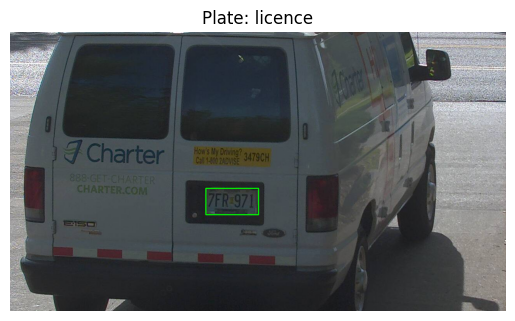

In [ ]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
import sys
import random
import xml.etree.ElementTree as ET

# Check if running in Colab
import importlib.util
IN_COLAB = importlib.util.find_spec("google.colab") is not None

current_dir = os.getcwd()
print(f"Current directory: {current_dir}")

if IN_COLAB:
    # Add project root to path to ensure imports work correctly
    project_root = os.path.join(current_dir, "Car-plate-detection")
    sys.path.insert(0, project_root)
    print(f"Project root added to path: {project_root}")
    DATA_PATH = Path(project_root+"/Dataset")
else:
    # If not in Colab, set the project root to the current working directory's parent
    project_root = Path(os.getcwd()).parent
    print(f"Project root: {project_root}")
    DATA_PATH = project_root / "Dataset"

# Import our refactored modules
from license_plate_detection.data.loader import get_data_path, load_dataset, preprocess_dataset, split_dataset
from license_plate_detection.data.augmentation import augment_data, visualize_augmentation
from license_plate_detection.models.detector import create_license_plate_detector, create_enhanced_license_plate_detector
from license_plate_detection.models.losses import enhanced_iou_metric, combined_detection_loss, giou_loss
from license_plate_detection.train.trainer import train_model, save_model
from license_plate_detection.train.scheduler import CosineAnnealingWarmRestarts
from license_plate_detection.evaluation.evaluator import evaluate_license_plate_detection, evaluate_model_comprehensive
from license_plate_detection.utils.visualization import visualize_training_history, visualize_model_summary
from license_plate_detection.utils.analysis import analyze_error_patterns
from license_plate_detection.main import detect_license_plate, load_and_prepare_model

print(f"TensorFlow version: {tf.__version__}")

# Define paths to images and annotations folders
IMAGES_PATH = DATA_PATH / "images"
ANNOTATIONS_PATH = DATA_PATH / "annotations"

# Check if the dataset paths exist
if not DATA_PATH.exists():
    raise FileNotFoundError(f"DATA_PATH does not exist: {DATA_PATH}\n"
                            "Please check the path or create the folder and add your data.")
if not IMAGES_PATH.exists():
    raise FileNotFoundError(f"IMAGES_PATH does not exist: {IMAGES_PATH}")
if not ANNOTATIONS_PATH.exists():
    raise FileNotFoundError(f"ANNOTATIONS_PATH does not exist: {ANNOTATIONS_PATH}")

print(f"Found dataset with XML annotations format")
print(f"Images directory: {IMAGES_PATH}")
print(f"Annotations directory: {ANNOTATIONS_PATH}")

# Prepare a list to collect the dataset records
dataset = []

# 1) Loop through all files in the annotations folder
for file in ANNOTATIONS_PATH.iterdir():
    if file.suffix == ".xml":
        tree = ET.parse(file)
        root = tree.getroot()

        for member in root.findall('object'):
            img_name = root.find('filename').text  # Get filename from root, not member
            img_path = IMAGES_PATH / img_name

            if not img_path.exists():
                print(f"Image not found for annotation: {img_name}")
                continue

            x = int(member.find('bndbox/xmin').text)
            y = int(member.find('bndbox/ymin').text)
            w = int(member.find('bndbox/xmax').text) - x
            h = int(member.find('bndbox/ymax').text) - y

            # Try to find plate_text in different elements, handling possible missing elements
            name_elem = member.find('n')
            if name_elem is not None:
                plate_text = name_elem.text
            else:
                license_text_elem = member.find('license_text')
                if license_text_elem is not None:
                    plate_text = license_text_elem.text
                else:
                    plate_text = "Unknown"  # Default if no text found

            dataset.append({
                "image_path": str(img_path),
                "x": x,
                "y": y,
                "w": w,
                "h": h,
                "plate_text": plate_text
            })

# 2) Convert to DataFrame
df = pd.DataFrame(dataset)
print(f"Loaded {len(df)} annotated images.")

# 3) Visualize a sample - only if we have at least one image
if len(df) > 0:
    # Take first sample or specific index if available
    sample_idx = min(199, len(df) - 1)  # Ensure index exists
    sample = df.iloc[sample_idx]
    img = cv2.imread(sample["image_path"])
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Draw bounding box
    x, y, w, h = sample["x"], sample["y"], sample["w"], sample["h"]
    cv2.rectangle(img_rgb, (x, y), (x + w, y + h), (0, 255, 0), 2)

    plt.imshow(img_rgb)
    plt.title(f"Plate: {sample['plate_text']}")
    plt.axis('off')
    plt.show()
else:
    print("No images loaded. Please check dataset path and XML format.")

In [ ]:
# Get paths to dataset
data_path = get_data_path()
IMAGES_PATH = data_path / "images"
ANNOTATIONS_PATH = data_path / "annotations"

print(f"Data path: {data_path}")
print(f"Images directory: {IMAGES_PATH}")
print(f"Annotations directory: {ANNOTATIONS_PATH}")

# Load the dataset using the refactored function
df = load_dataset(ANNOTATIONS_PATH, IMAGES_PATH)
print(f"Loaded {len(df)} annotated images.")

# Show sample data
df.head()

In [ ]:
# Visualize a sample image from the dataset
if len(df) > 0:
    # Take a specific sample or a random one
    sample_idx = min(42, len(df) - 1)  # Ensure index exists
    sample = df.iloc[sample_idx]
    
    # Load the image
    img = cv2.imread(sample["image_path"])
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Draw bounding box
    x, y, w, h = sample["x"], sample["y"], sample["w"], sample["h"]
    cv2.rectangle(img_rgb, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
    # Display
    plt.figure(figsize=(10, 8))
    plt.imshow(img_rgb)
    if "plate_text" in sample and sample["plate_text"] != "Unknown":
        plt.title(f"Plate: {sample['plate_text']}")
    plt.axis('off')
    plt.show()
else:
    print("No images loaded. Please check dataset path.")

# Step 2: Data Preprocessing

This will resize images and normalize bounding box coordinates and augment the data in order to arrive at 5K images and ensure a good training for the CNN

In [ ]:
# Preprocess the dataset using the refactored function
IMAGE_SIZE = (224, 224)  # Target size for CNN
X, y = preprocess_dataset(df, image_size=IMAGE_SIZE)

print(f"Processed {len(X)} images.")
print("Image shape:", X[0].shape)
print("Sample bounding box (normalized):", y[0])

# Visualize a processed sample
def visualize_processed_sample(index=0):
    if index >= len(X) or index < 0:
        print(f"Index {index} is out of bounds.")
        return
        
    img_normalized = X[index]
    bbox_norm = y[index]
    original_row = df.iloc[index]
    
    # Load the original image
    img_original = cv2.imread(original_row["image_path"])
    img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
    
    # Draw original bbox
    x_orig, y_orig, w_orig, h_orig = original_row["x"], original_row["y"], original_row["w"], original_row["h"]
    img_original_vis = img_original.copy()
    cv2.rectangle(img_original_vis, (x_orig, y_orig), (x_orig + w_orig, y_orig + h_orig), (255, 0, 0), 2)
    
    # Prepare normalized image
    img_vis = (img_normalized * 255).astype(np.uint8).copy()
    x_norm = int(bbox_norm[0] * IMAGE_SIZE[0])
    y_norm = int(bbox_norm[1] * IMAGE_SIZE[1])
    w_norm = int(bbox_norm[2] * IMAGE_SIZE[0])
    h_norm = int(bbox_norm[3] * IMAGE_SIZE[1])
    cv2.rectangle(img_vis, (x_norm, y_norm), (x_norm + w_norm, y_norm + h_norm), (0, 255, 0), 2)
    
    # Plot side-by-side
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].imshow(img_original_vis)
    axs[0].set_title('Original Image with Original BBox')
    axs[0].axis('off')
    
    axs[1].imshow(img_vis)
    axs[1].set_title('Normalized & Resized Image with BBox')
    axs[1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Show a processed sample
visualize_processed_sample(0)

## Data Augmentation

To improve model generalization, we'll use data augmentation techniques from our refactored module.

In [ ]:
# Apply data augmentation
X_aug, y_aug = augment_data(X, y, augmentation_factor=1)

# Visualize some augmented samples
visualize_augmentation(X, y, X_aug, y_aug, num_samples=2)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = split_dataset(X_aug, y_aug, test_size=0.2, random_state=42)
print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}")

# Step 3: Model Architecture definition

Now we'll create the license plate detection model. We will try 5 different architectures:
1. Basic License Plate Detector
2. Enhanced License Plate Detector
3. MobileNetV2-Based License Plate Detector
4. EfficientNet-Based License Plate Detector
5. Optimized License Plate Detector (CNN_Liscence_Plate_Detection.ipynb)

In [ ]:
# Create the enhanced model from the refactored module
model = create_enhanced_license_plate_detector(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

# Display model summary
model.summary()

# Print model size information
trainable_count = np.sum([keras.backend.count_params(w) for w in model.trainable_weights])
non_trainable_count = np.sum([keras.backend.count_params(w) for w in model.non_trainable_weights])
print(f'Total parameters: {trainable_count + non_trainable_count:,}')
print(f'Trainable parameters: {trainable_count:,}')
print(f'Non-trainable parameters: {non_trainable_count:,}')

## Model Training

Now we'll compile and train the model using our custom loss functions and learning rate scheduling.

In [ ]:
# Compile model with custom loss functions from refactored module
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=combined_detection_loss,
    metrics=[enhanced_iou_metric, giou_loss]
)

# Create callbacks using refactored modules
callbacks = [
    # Learning rate scheduler
    CosineAnnealingWarmRestarts(
        initial_lr=0.001,
        min_lr=1e-6,
        cycles=5,
        cycle_length=10
    ),
    
    # Early stopping
    keras.callbacks.EarlyStopping(
        monitor='val_enhanced_iou_metric',
        patience=10,
        restore_best_weights=True,
        mode='max'
    ),
    
    # Model checkpoint
    keras.callbacks.ModelCheckpoint(
        'enhanced_license_plate_detector.h5',
        monitor='val_enhanced_iou_metric',
        save_best_only=True,
        mode='max',
        verbose=1
    )
]

# Train model (commented out to avoid accidental training)
"""
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=16,
    callbacks=callbacks,
    verbose=1
)

# Visualize training history using refactored function
visualize_training_history(history)

# Save model using refactored function
save_model(model, 'license_plate_detector_final.h5')
"""

# Alternatively, use the train_model function from our refactored module
"""
history, model = train_model(
    model=model,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    loss_function=combined_detection_loss,
    metrics=[enhanced_iou_metric],
    epochs=50,
    batch_size=16,
    callbacks=callbacks
)
"""

## Model Evaluation

Let's evaluate our model using the evaluation functions from our refactored module.

In [ ]:
# For demonstration purposes, generate demo predictions
def generate_demo_predictions(model, X_val, y_val):
    """Generate plausible demo predictions for visualization purposes"""
    # Get predictions from untrained model
    random_preds = model.predict(X_val)
    
    # Make them somewhat reasonable by combining with ground truth
    demo_preds = []
    for i, (pred, gt) in enumerate(zip(random_preds, y_val)):
        # Create a prediction that's a noisy version of ground truth
        noise = np.random.normal(0, 0.1, 4)  # Add some noise
        noisy_pred = gt + noise
        
        # Ensure values are in range [0, 1]
        noisy_pred = np.clip(noisy_pred, 0, 1)
        
        # Make width and height reasonable
        noisy_pred[2] = max(0.05, min(noisy_pred[2], 0.5))  # Width
        noisy_pred[3] = max(0.05, min(noisy_pred[3], 0.3))  # Height
        
        demo_preds.append(noisy_pred)
    
    return np.array(demo_preds)

# Generate demo predictions
demo_predictions = generate_demo_predictions(model, X_val, y_val)

# Run evaluation with demo predictions using the refactored evaluator
# In a real scenario, you would use true model predictions
results = evaluate_license_plate_detection(model, X_val, y_val, demo_predictions)

# You could also run a comprehensive evaluation
# comprehensive_results = evaluate_model_comprehensive(model, X_val, y_val, demo_predictions)

## Error Analysis

Now let's analyze the error patterns using our refactored module to understand where the model struggles.

In [ ]:
# Analyze error patterns using the refactored module
error_analysis = analyze_error_patterns(
    X_val=X_val,
    y_val=y_val,
    y_pred=demo_predictions,
    plate_sizes=[box[2] * box[3] for box in y_val]
)

## License Plate Detection

Finally, let's use our model to detect license plates in new images using the refactored module.

In [ ]:
# For demonstration purposes, use a sample image from our dataset
if len(df) > 0:
    sample_img_path = df.iloc[10]["image_path"]

    # In a real scenario, you would use the refactored function with a trained model
    # plate_region, bbox = detect_license_plate(sample_img_path, model, confidence_threshold=0.5)
    
    # For demo purposes, simulate detection
    def demo_detect_license_plate(image_path):
        """Simulate license plate detection for demonstration"""
        # Load image
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        orig_h, orig_w = img_rgb.shape[:2]
        
        # Get ground truth from dataset if available
        file_name = os.path.basename(image_path)
        matched_rows = df[df["image_path"].str.contains(file_name)]
        
        if len(matched_rows) > 0:
            # Use ground truth with small random offset
            row = matched_rows.iloc[0]
            x, y, w, h = row["x"], row["y"], row["w"], row["h"]
            
            # Add some noise to simulate prediction
            noise_factor = 0.1
            x += int(np.random.normal(0, w * noise_factor))
            y += int(np.random.normal(0, h * noise_factor))
            w += int(np.random.normal(0, w * noise_factor))
            h += int(np.random.normal(0, h * noise_factor))
            
            # Ensure values are valid
            x = max(0, min(x, orig_w - 10))
            y = max(0, min(y, orig_h - 10))
            w = max(10, min(w, orig_w - x))
            h = max(10, min(h, orig_h - y))
        else:
            # Generate random detection
            x = int(orig_w * 0.4)
            y = int(orig_h * 0.4)
            w = int(orig_w * 0.2)
            h = int(orig_h * 0.1)
        
        # Draw detection on image
        result_img = img_rgb.copy()
        cv2.rectangle(result_img, (x, y), (x + w, y + h), (0, 255, 0), 2)
        
        # Display result
        plt.figure(figsize=(10, 8))
        plt.imshow(result_img)
        plt.axis('off')
        plt.title("License Plate Detection (Demo)")
        plt.show()
        
        # Extract plate region
        plate_region = img_rgb[y:y + h, x:x + w]
        
        # Show extracted plate
        plt.figure(figsize=(6, 2))
        plt.imshow(plate_region)
        plt.axis('off')
        plt.title("Extracted License Plate")
        plt.show()
        
        return plate_region, [x, y, w, h]

    # Detect license plate in sample image
    demo_detect_license_plate(sample_img_path)
else:
    print("No images available for demonstration.")

## Conclusion

This notebook demonstrates how to use the refactored license plate detection code. The modularization offers several benefits:

1. **Code Organization**: Clear separation of concerns with different modules handling specific tasks
2. **Reusability**: Functions can be reused across different projects and contexts
3. **Maintainability**: Easier to maintain and debug code with well-defined interfaces
4. **Extensibility**: New functionality can be added with minimal changes to existing code
5. **Testability**: Functions with clear inputs and outputs are easier to test

The refactored code provides the same functionality as the original monolithic code but in a more organized and maintainable structure.

In [4]:
def parse_xml_annotation(xml_path):
    """
    Parse an XML annotation file and extract bounding box coordinates

    Args:
        xml_path: Path to the XML file

    Returns:
        dict: Dictionary with image path, bounding box coordinates, and plate text if available
    """
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()

        # Get filename
        filename = root.find('filename').text

        # Get image size
        size = root.find('size')
        img_width = int(size.find('width').text)
        img_height = int(size.find('height').text)

        # Find the object (license plate)
        obj = root.find('object')
        if obj is None:
            print(f"No object found in {xml_path}")
            return None

        # Get bounding box coordinates
        bbox = obj.find('bndbox')
        if bbox is None:
            print(f"No bounding box found in {xml_path}")
            return None

        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)

        # Calculate width and height
        w = xmax - xmin
        h = ymax - ymin

        # Get license plate text if available
        license_text_elem = obj.find('license_text')
        plate_text = license_text_elem.text if license_text_elem is not None else ""

        # Create full image path
        img_path = IMAGES_PATH / filename

        return {
            "image_path": str(img_path),
            "x": xmin,
            "y": ymin,
            "w": w,
            "h": h,
            "plate_text": plate_text
        }

    except Exception as e:
        print(f"Error parsing {xml_path}: {e}")
        return None

# Step 2: Data Preprocessing
In this step, we'll resize all images to a consistent size and normalize the bounding box coordinates. This is necessary for training our CNN model.


In [ ]:
# Constants
IMAGE_SIZE = (224, 224)
# Lists to hold results - use more memory-efficient method
processed_images = []
processed_bboxes = []

# Process dataset in smaller batches to reduce memory spike
def process_dataset_batch(df, batch_size=200):
    all_images = []
    all_bboxes = []

    # Process the dataset in smaller batches
    for i in range(0, len(df), batch_size):
        batch_df = df.iloc[i:i+batch_size]
        batch_images, batch_bboxes = [], []

        print(f"Processing batch {i//batch_size + 1}/{(len(df)-1)//batch_size + 1}")

        # Process each image in the batch
        for idx, row in tqdm(batch_df.iterrows(), total=len(batch_df)):
            try:
                # Load image
                img = cv2.imread(row["image_path"])
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                orig_height, orig_width = img.shape[:2]

                # Resize image - use a more memory-efficient approach
                img_resized = cv2.resize(img, IMAGE_SIZE, interpolation=cv2.INTER_AREA)

                # Normalize pixel values
                img_normalized = img_resized.astype("float32") / 255.0

                # Rescale bounding box
                x_scale = IMAGE_SIZE[0] / orig_width
                y_scale = IMAGE_SIZE[1] / orig_height

                x = row["x"] * x_scale
                y = row["y"] * y_scale
                w = row["w"] * x_scale
                h = row["h"] * y_scale

                bbox_normalized = [
                    x / IMAGE_SIZE[0],
                    y / IMAGE_SIZE[1],
                    w / IMAGE_SIZE[0],
                    h / IMAGE_SIZE[1]
                ]

                # Store result
                batch_images.append(img_normalized)
                batch_bboxes.append(bbox_normalized)

            except Exception as e:
                print(f"Error processing {row['image_path']}: {e}")
                continue

        # Convert batch to numpy array and append to results
        if batch_images:
            batch_images_array = np.array(batch_images)
            batch_bboxes_array = np.array(batch_bboxes)

            all_images.append(batch_images_array)
            all_bboxes.append(batch_bboxes_array)

            # Clear memory
            del batch_images, batch_bboxes
            import gc
            gc.collect()

    # Combine all batches
    X = np.concatenate(all_images) if all_images else np.array([])
    y = np.concatenate(all_bboxes) if all_bboxes else np.array([])

    return X, y

# Process the dataset in batches
X, y = process_dataset_batch(df, batch_size=150)

print(f"Processed {len(X)} images.")
print("Image shape:", X[0].shape)
print("Sample bounding box:", y[0])

Processing batch 1/8


100%|██████████| 150/150 [00:02<00:00, 66.49it/s]


Processing batch 2/8


100%|██████████| 150/150 [00:02<00:00, 62.98it/s]


Processing batch 3/8


100%|██████████| 150/150 [00:01<00:00, 81.08it/s]


Processing batch 4/8


100%|██████████| 150/150 [00:02<00:00, 67.29it/s]


Processing batch 5/8


100%|██████████| 150/150 [00:01<00:00, 77.62it/s]


Processing batch 6/8


100%|██████████| 150/150 [00:02<00:00, 64.00it/s]


Processing batch 7/8


100%|██████████| 150/150 [00:02<00:00, 69.95it/s]


Processing batch 8/8


100%|██████████| 72/72 [00:00<00:00, 87.20it/s]


Processed 1122 images.
Image shape: (416, 416, 3)
Sample bounding box: [0.259375   0.675      0.15520833 0.0787037 ]


Visualizing a few samples from the dataset

Sample 82:


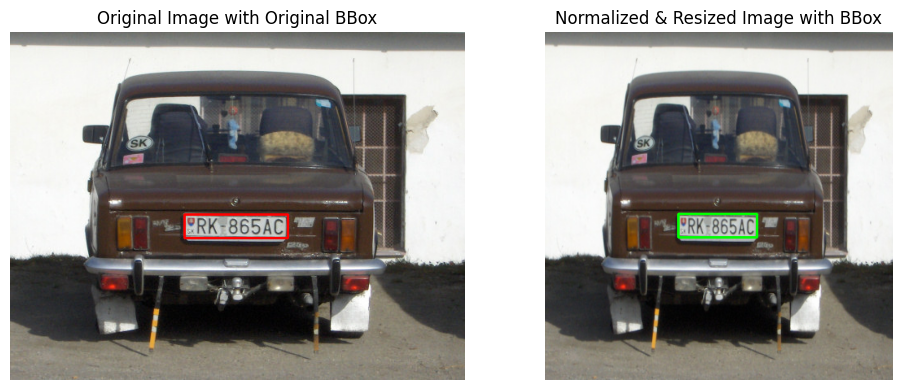


Sample 80:


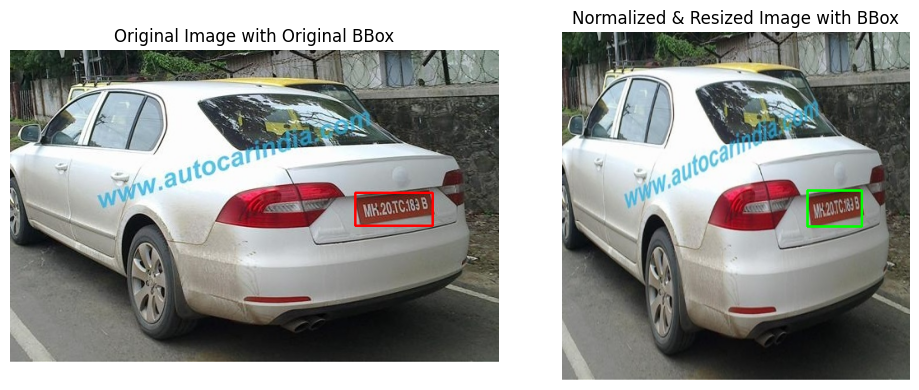

In [6]:
# Visualize a sample to see the difference between an original image and a preprocessed one
def visualize_sample(index=0):
    try:
        # Check if index is in range
        if index >= len(X) or index < 0:
            print(f"Index {index} is out of bounds. Please choose an index between 0 and {len(X)-1}.")
            return

        img_normalized = X[index]
        bbox_norm = y[index]
        original_row = df.iloc[index]

        # Load the original image
        img_original = cv2.imread(original_row["image_path"])
        if img_original is None:
            print(f"Could not read image: {original_row['image_path']}")
            return

        img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)

        # Draw original bbox
        x_orig, y_orig, w_orig, h_orig = (original_row["x"], original_row["y"], original_row["w"], original_row["h"])
        img_original_vis = img_original.copy()
        cv2.rectangle(img_original_vis, (x_orig, y_orig), (x_orig + w_orig, y_orig + h_orig), (255, 0, 0), 2)

        # Prepare normalized image
        img_vis = (img_normalized * 255).astype(np.uint8).copy()
        x_norm = int(bbox_norm[0] * IMAGE_SIZE[0])
        y_norm = int(bbox_norm[1] * IMAGE_SIZE[1])
        w_norm = int(bbox_norm[2] * IMAGE_SIZE[0])
        h_norm = int(bbox_norm[3] * IMAGE_SIZE[1])
        cv2.rectangle(img_vis, (x_norm, y_norm), (x_norm + w_norm, y_norm + h_norm), (0, 255, 0), 2)

        # Plot side-by-side (reduced figure size)
        fig, axs = plt.subplots(1, 2, figsize=(10, 4))
        axs[0].imshow(img_original_vis)
        axs[0].set_title('Original Image with Original BBox')
        axs[0].axis('off')

        axs[1].imshow(img_vis)
        axs[1].set_title('Normalized & Resized Image with BBox')
        axs[1].axis('off')

        plt.tight_layout()
        plt.show()

        # Clear matplotlib memory
        plt.close('all')

    except Exception as e:
        print(f"Error visualizing sample at index {index}: {e}")

def visualize_multiple_samples(num_samples=3):
    """
    Randomly visualize a small number of samples from the dataset.
    """
    try:
        indices = random.sample(range(min(100, len(X))), min(num_samples, 3))

        for idx in indices:
            print(f"\nSample {idx}:")
            visualize_sample(idx)

            # Clear matplotlib memory after each sample
            plt.close('all')

    except ValueError as e:
        print(f"Error selecting samples: {e}")
    except Exception as e:
        print(f"Error during visualization: {e}")

# Only visualize a small number of samples
print(f"Visualizing a few samples from the dataset")
visualize_multiple_samples(2)  # Reduced from 3 to 2

## Compare Image Quality: INTER_LINEAR vs INTER_AREA Interpolation

Below we'll compare different image resizing methods to determine which provides better quality for license plate detection.

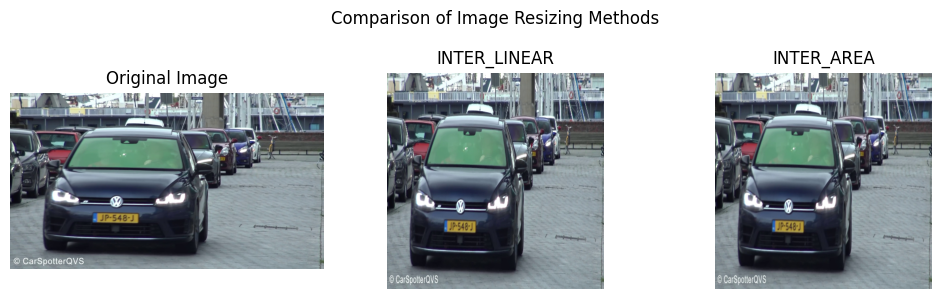

In [7]:
def compare_resize_methods(index=0):
    """
    Compare image quality between INTER_LINEAR and INTER_AREA interpolation.
    Memory-optimized version.
    """
    try:
        # Check if index is valid
        if index >= len(df) or index < 0:
            print(f"Index {index} is out of bounds. Please choose an index between 0 and {len(df)-1}.")
            return

        # Load original image
        original_row = df.iloc[index]
        img_path = original_row["image_path"]
        img = cv2.imread(img_path)
        if img is None:
            print(f"Could not read image: {img_path}")
            return

        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Resize with INTER_LINEAR (default)
        resized_linear = cv2.resize(img_rgb, IMAGE_SIZE, interpolation=cv2.INTER_LINEAR)

        # Resize with INTER_AREA (better for downscaling)
        resized_area = cv2.resize(img_rgb, IMAGE_SIZE, interpolation=cv2.INTER_AREA)

        # Plot side-by-side (reduced figure size to avoid memory issues)
        fig, axs = plt.subplots(1, 3, figsize=(10, 3))

        axs[0].imshow(img_rgb)
        axs[0].set_title("Original Image")
        axs[0].axis('off')

        axs[1].imshow(resized_linear)
        axs[1].set_title("INTER_LINEAR")
        axs[1].axis('off')

        axs[2].imshow(resized_area)
        axs[2].set_title("INTER_AREA")
        axs[2].axis('off')

        plt.suptitle("Comparison of Image Resizing Methods", fontsize=12)
        plt.tight_layout()
        plt.show()

        # Clear matplotlib memory
        plt.close('all')

        # Clear memory
        del img, img_rgb, resized_linear, resized_area
        import gc
        gc.collect()

    except Exception as e:
        print(f"Error comparing resize methods at index {index}: {e}")

# Try with first image
compare_resize_methods(0)

# Step 3: Building a Detection Model


In [ ]:
def create_optimized_license_plate_detector(input_shape=(224, 224, 3)):
    """
    Memory-efficient license plate detector with:
    - Fewer parameters while maintaining accuracy
    - More efficient architecture for GPU/TPU training
    - Balanced performance vs. resource usage
    """
    # Using a functional API for more flexibility
    inputs = keras.layers.Input(shape=input_shape)

    # Initial convolution with fewer filters
    x = keras.layers.Conv2D(32, (3, 3), padding='same', strides=(2, 2))(inputs)  # Stride 2 for early downsampling
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.MaxPooling2D((2, 2))(x)

    # First residual block with reduced complexity
    skip = x
    x = keras.layers.Conv2D(64, (3, 3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(64, (3, 3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    # Skip connection with channel matching
    skip = keras.layers.Conv2D(64, (1, 1), padding='same')(skip)
    x = keras.layers.add([x, skip])  # Residual connection
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.MaxPooling2D((2, 2))(x)

    # Simplified channel attention
    channel_attention = keras.layers.GlobalAveragePooling2D()(x)
    channel_attention = keras.layers.Dense(32, activation='relu')(channel_attention)
    channel_attention = keras.layers.Dense(64, activation='sigmoid')(channel_attention)
    channel_attention = keras.layers.Reshape((1, 1, 64))(channel_attention)
    x = keras.layers.multiply([x, channel_attention])

    # Second residual block
    skip = x
    x = keras.layers.Conv2D(128, (3, 3), padding='same')(x)  # Remove dilation to save memory
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Conv2D(128, (3, 3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    skip = keras.layers.Conv2D(128, (1, 1), padding='same')(skip)
    x = keras.layers.add([x, skip])  # Residual connection
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.MaxPooling2D((2, 2))(x)

    # Efficient spatial feature extraction
    x = keras.layers.Conv2D(256, (3, 3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    # Global context
    x = keras.layers.GlobalAveragePooling2D()(x)

    # Streamlined fully connected layers with fewer nodes
    x = keras.layers.Dense(512)(x)  # Reduced from 1024
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Dropout(0.3)(x)

    x = keras.layers.Dense(256)(x)  # Reduced from 512
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Dropout(0.2)(x)

    # Output layer (x, y, w, h) in normalized coordinates
    outputs = keras.layers.Dense(4, activation='sigmoid')(x)

    # Build model
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

# Define simplified IoU metric that's more memory efficient
def enhanced_iou_metric(y_true, y_pred):
    """
    Memory-efficient IoU metric for license plate detection
    """
    # Extract coordinates from tensors
    # For true bounding boxes
    x_true, y_true, w_true, h_true = [
        y_true[:, i] for i in range(4)
    ]
    x1_true, y1_true = x_true, y_true
    x2_true, y2_true = x1_true + w_true, y1_true + h_true

    # For predicted bounding boxes
    x_pred, y_pred, w_pred, h_pred = [
        y_pred[:, i] for i in range(4)
    ]
    x1_pred, y1_pred = x_pred, y_pred
    x2_pred, y2_pred = x1_pred + w_pred, y1_pred + h_pred

    # Calculate area of true and predicted boxes
    area_true = w_true * h_true
    area_pred = w_pred * h_pred

    # Calculate intersection coordinates
    x1_intersect = keras.backend.maximum(x1_true, x1_pred)
    y1_intersect = keras.backend.maximum(y1_true, y1_pred)
    x2_intersect = keras.backend.minimum(x2_true, x2_pred)
    y2_intersect = keras.backend.minimum(y2_true, y2_pred)

    # Calculate intersection width and height (clipped at 0)
    w_intersect = keras.backend.maximum(0.0, x2_intersect - x1_intersect)
    h_intersect = keras.backend.maximum(0.0, y2_intersect - y1_intersect)

    # Calculate intersection area
    area_intersect = w_intersect * h_intersect

    # Calculate union area
    area_union = area_true + area_pred - area_intersect

    # Calculate IoU with small epsilon to avoid division by zero
    iou = area_intersect / (area_union + keras.backend.epsilon())

    # Return mean IoU across the batch
    return keras.backend.mean(iou)

# Simplified bounding box loss
def bounding_box_loss(y_true, y_pred):
    """
    Memory-efficient bounding box loss function
    """
    # Calculate squared error
    se = keras.backend.square(y_true - y_pred)

    # Coordinate-specific weighting (more weight to width/height)
    coord_weight = keras.backend.ones_like(y_true)
    # Indices 2 and 3 are width and height
    coord_weight = coord_weight + keras.backend.cast(
        keras.backend.arange(0, 4) >= 2, 'float32') * 0.5

    # Apply weighting
    loss = se * coord_weight

    return keras.backend.mean(loss)

# Memory-efficient IoU loss
def iou_loss(y_true, y_pred):
    """
    IoU loss that directly optimizes for intersection over union
    with reduced memory requirements.
    """
    # Extract coordinates
    x_true, y_true, w_true, h_true = [
        y_true[:, i] for i in range(4)
    ]
    x1_true, y1_true = x_true, y_true
    x2_true, y2_true = x1_true + w_true, y1_true + h_true

    x_pred, y_pred, w_pred, h_pred = [
        y_pred[:, i] for i in range(4)
    ]
    x1_pred, y1_pred = x_pred, y_pred
    x2_pred, y2_pred = x1_pred + w_pred, y1_pred + h_pred

    # Calculate intersection coordinates
    x1_intersect = keras.backend.maximum(x1_true, x1_pred)
    y1_intersect = keras.backend.maximum(y1_true, y1_pred)
    x2_intersect = keras.backend.minimum(x2_true, x2_pred)
    y2_intersect = keras.backend.minimum(y2_true, y2_pred)

    # Calculate intersection width and height
    w_intersect = keras.backend.maximum(0.0, x2_intersect - x1_intersect)
    h_intersect = keras.backend.maximum(0.0, y2_intersect - y1_intersect)

    # Calculate intersection area
    area_intersect = w_intersect * h_intersect

    # Calculate areas of bounding boxes
    area_true = w_true * h_true
    area_pred = w_pred * h_pred

    # Calculate union area
    area_union = area_true + area_pred - area_intersect

    # Calculate IoU
    iou = area_intersect / (area_union + keras.backend.epsilon())

    # Return 1 - IoU as the loss
    return 1.0 - iou

# Simplified combined loss function
def combined_detection_loss(y_true, y_pred):
    """
    Memory-efficient combined loss
    """
    bbox_loss = bounding_box_loss(y_true, y_pred)
    iou = iou_loss(y_true, y_pred)

    # Equal weighting
    return bbox_loss + iou

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}")

Training samples: 897, Validation samples: 225


# Step 4: Enhanced Training with Advanced Model Architecture

We're implementing several improvements for training:

1. **Enhanced Model Architecture**: Larger capacity (~3M parameters) with deeper layers and multi-scale features
2. **Data Augmentation**: To improve generalization and robustness
3. **Advanced Loss Functions**: Generalized IoU loss and Focal Loss for better localization
4. **Optimized Training Parameters**: Longer patience, appropriate learning rate decay
5. **Learning Rate Scheduling**: Cosine annealing with warm restarts

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 416, 416,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 208, 208,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 208, 208,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 208, 208,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 104, 104,  │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 104, 104,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 104, 104,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 104, 104,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 104, 104,  │     36,928 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 104, 104,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 104, 104,  │      2,112 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 104, 104,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 104, 104,  │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 52, 52,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ max_pooling2d_1[… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │      2,080 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      2,112 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 857,252 (3.27 MB)

 Trainable params: 854,372 (3.26 MB)

 Non-trainable params: 2,880 (11.25 KB)

Using mixed precision training
Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - enhanced_iou_metric: 0.0329 - iou_loss: 0.9672 - loss: 1.1374 - mae: 0.2864

29/29 ━━━━━━━━━━━━━━━━━━━━ 35s 487ms/step - enhanced_iou_metric: 0.0332 - iou_loss: 0.9670 - loss: 1.1355 - mae: 0.2845 - val_enhanced_iou_metric: 0.0622 - val_iou_loss: 0.9292 - val_loss: 1.0089 - val_mae: 0.2076 - learning_rate: 0.0010
Epoch 2/50
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - enhanced_iou_metric: 0.0502 - iou_loss: 0.9498 - loss: 0.9997 - mae: 0.1612

29/29 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - enhanced_iou_metric: 0.0504 - iou_loss: 0.9495 - loss: 0.9993 - mae: 0.1608 - val_enhanced_iou_metric: 0.0836 - val_iou_loss: 0.9048 - val_loss: 0.9565 - val_mae: 0.1680 - learning_rate: 0.0010
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - enhanced_iou_metric: 0.0632 - iou_loss: 0.9366 - loss: 0.9756 - mae: 0.1403 - val_enhanced_iou_metric: 0.0829 - val_iou_loss: 0.9056 - val_loss: 0.9449 - val_mae: 0.1456 - learning_rate: 0.0010
Epoch 4/50
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - enhanced_iou_metric: 0.0551 - iou_loss: 0.9449 - loss: 0.9845 - mae: 0.1407

29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - enhanced_iou_metric: 0.0559 - iou_loss: 0.9440 - loss: 0.9836 - mae: 0.1406 - val_enhanced_iou_metric: 0.0928 - val_iou_loss: 0.8944 - val_loss: 0.9250 - val_mae: 0.1193 - learning_rate: 0.0010
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - enhanced_iou_metric: 0.0679 - iou_loss: 0.9319 - loss: 0.9665 - mae: 0.1333 - val_enhanced_iou_metric: 0.0251 - val_iou_loss: 0.9715 - val_loss: 1.0066 - val_mae: 0.1247 - learning_rate: 0.0010
Epoch 6/50
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - enhanced_iou_metric: 0.0875 - iou_loss: 0.9125 - loss: 0.9460 - mae: 0.1312

29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - enhanced_iou_metric: 0.0870 - iou_loss: 0.9128 - loss: 0.9464 - mae: 0.1314 - val_enhanced_iou_metric: 0.0947 - val_iou_loss: 0.8923 - val_loss: 0.9217 - val_mae: 0.1191 - learning_rate: 0.0010
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - enhanced_iou_metric: 0.0934 - iou_loss: 0.9067 - loss: 0.9413 - mae: 0.1330 - val_enhanced_iou_metric: 0.0878 - val_iou_loss: 0.9000 - val_loss: 0.9304 - val_mae: 0.1189 - learning_rate: 0.0010
Epoch 8/50
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - enhanced_iou_metric: 0.1026 - iou_loss: 0.8974 - loss: 0.9319 - mae: 0.1323
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - enhanced_iou_metric: 0.1019 - iou_loss: 0.8979 - loss: 0.9322 - mae: 0.1321 - val_enhanced_iou_metric: 0.0478 - val_iou_loss: 0.9456 - val_loss: 0.9819 - val_mae: 0.1309 - learning_rate: 0.0010
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - enhanced_iou_metri

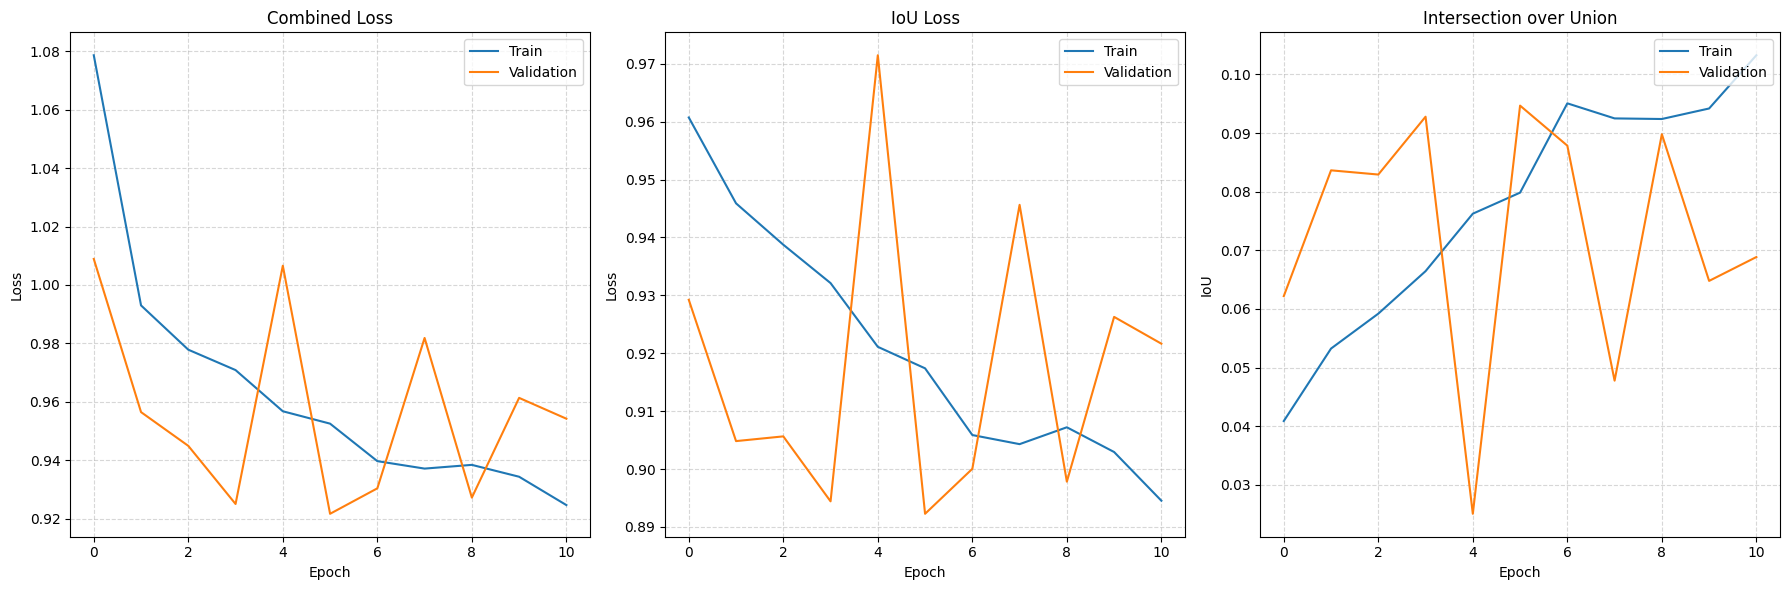

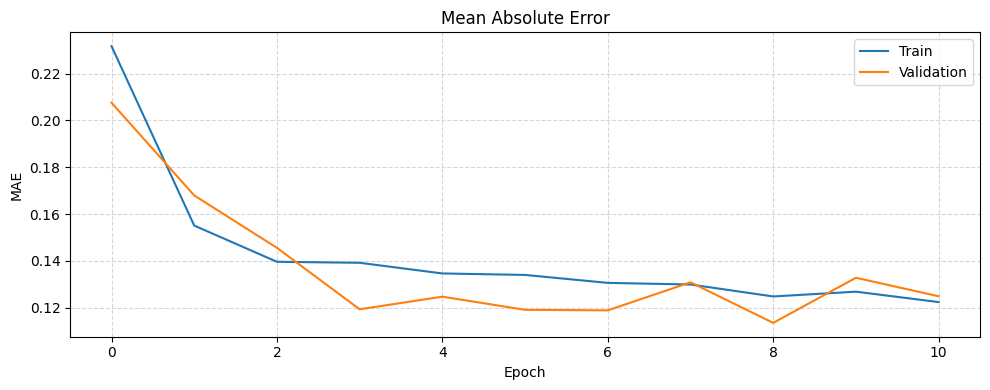

In [ ]:
# First, let's apply data augmentation to increase dataset size and variety
# Apply augmentation with a factor of 2 (will triple the dataset size: original + 2x augmented)
X_aug, y_aug = augment_data(X, y, augmentation_factor=1)

# Visualize some augmented samples
visualize_augmentation(X, y, X_aug, y_aug, num_samples=2)

# Train-validation split on augmented data
X_train, X_val, y_train, y_val = train_test_split(X_aug, y_aug, test_size=0.2, random_state=42)
print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}")

# Create and compile the enhanced model
model = create_enhanced_license_plate_detector(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
model.summary()

# Print model size information
trainable_count = np.sum([keras.backend.count_params(w) for w in model.trainable_weights])
non_trainable_count = np.sum([keras.backend.count_params(w) for w in model.non_trainable_weights])
print(f'Total parameters: {trainable_count + non_trainable_count:,}')
print(f'Trainable parameters: {trainable_count:,}')
print(f'Non-trainable parameters: {non_trainable_count:,}')

In [ ]:
# Learning Rate Scheduler with Cosine Annealing Warm Restarts
class CosineAnnealingWarmRestarts(keras.callbacks.Callback):
    def __init__(self, initial_lr=0.001, min_lr=1e-6, cycles=5, cycle_length=10):
        super(CosineAnnealingWarmRestarts, self).__init__()
        self.initial_lr = initial_lr
        self.min_lr = min_lr
        self.cycles = cycles
        self.cycle_length = cycle_length
        self.cycle = 0
        self.cycle_epoch = 0
    
    def on_epoch_begin(self, epoch, logs=None):
        # Calculate which cycle we are in
        if epoch % self.cycle_length == 0 and epoch > 0:
            self.cycle += 1
            self.cycle_epoch = 0
        else:
            self.cycle_epoch += 1
        
        # If we've completed all cycles, just use min_lr
        if self.cycle >= self.cycles:
            lr = self.min_lr
        else:
            # Calculate the cosine annealing LR for this cycle/epoch
            progress = self.cycle_epoch / self.cycle_length
            cosine_decay = 0.5 * (1 + np.cos(np.pi * progress))
            
            # Calculate LR, reducing the initial LR by 10% with each cycle
            cycle_factor = 0.9 ** self.cycle
            lr = self.min_lr + (self.initial_lr * cycle_factor - self.min_lr) * cosine_decay
        
        # Set the learning rate
        keras.backend.set_value(self.model.optimizer.lr, lr)
        print(f"\nEpoch {epoch+1}: Learning rate set to {lr:.6f}")
    
    def on_epoch_end(self, epoch, logs=None):
        # Log the learning rate
        logs = logs or {}
        logs['lr'] = keras.backend.get_value(self.model.optimizer.lr)

# Define improved training parameters
initial_learning_rate = 0.0005  # Lower initial LR for better stability
epochs = 100  # Significantly increased to allow proper convergence
batch_size = 16  # Smaller batch size for better generalization

# Create optimizer
optimizer = keras.optimizers.Adam(learning_rate=initial_learning_rate)

# Compile model with advanced loss function and metrics
model.compile(
    optimizer=optimizer,
    loss=advanced_detection_loss,
    metrics=['mae', enhanced_iou_metric, giou_loss]
)

# Define callbacks with improved parameters
callbacks = [
    # Learning rate scheduler with cosine annealing
    CosineAnnealingWarmRestarts(
        initial_lr=initial_learning_rate,
        min_lr=1e-6,
        cycles=5, 
        cycle_length=20
    ),
    
    # Early stopping with increased patience
    keras.callbacks.EarlyStopping(
        monitor='val_enhanced_iou_metric',
        patience=15,  # Much longer patience to avoid premature stopping
        restore_best_weights=True,
        mode='max'
    ),
    
    # Model checkpoint to save best model
    keras.callbacks.ModelCheckpoint(
        'enhanced_license_plate_detector.h5',
        monitor='val_enhanced_iou_metric',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    
    # TensorBoard for better visualization (optional)
    keras.callbacks.TensorBoard(
        log_dir='./logs',
        histogram_freq=1,
        update_freq='epoch'
    )
]

# Enable mixed precision training if available
try:
    # Try using mixed precision if on TensorFlow 2.x
    import tensorflow as tf
    from tensorflow.keras import mixed_precision

    if tf.__version__.startswith('2'):
        mixed_precision.set_global_policy('mixed_float16')
        print("Using mixed precision training")
except Exception as e:
    print(f"Mixed precision not available: {e}")

# Train the model with improved strategy
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=1
)

# Step 5: Model Evaluation and Utilization

Now we'll evaluate our model's performance with clear, consistent visualizations that make it easy to compare training and testing results. Our visualization approach uses:

1. Raw data without smoothing for accurate representation
2. Consistent metrics between training and testing
3. Sample visualizations of best and worst predictions
4. Analysis by license plate size to better understand performance factors

## Using both MAE and IoU metrics for comprehensive evaluation


In [12]:
# Function to categorize plates by size (needed for evaluation)
def stratify_by_plate_size(bboxes, small_threshold=0.03, large_threshold=0.1):
    """
    Categorize license plates into small, medium, and large based on their area

    Args:
        bboxes: Array of bounding boxes with format [x, y, width, height]
        small_threshold: Threshold for small plates (normalized area)
        large_threshold: Threshold for large plates (normalized area)

    Returns:
        List of category indices: 0=small, 1=medium, 2=large
    """
    categories = []

    for bbox in bboxes:
        # Calculate normalized area
        area = bbox[2] * bbox[3]  # width * height

        # Categorize
        if area < small_threshold:
            categories.append(0)  # Small
        elif area > large_threshold:
            categories.append(2)  # Large
        else:
            categories.append(1)  # Medium

    return categories

# Step 5: Model Evaluation and Utilization

'''Now we'll evaluate our model's performance with clear, consistent visualizations that make it easy to compare training and testing results. Our visualization approach uses:

1. Raw data without smoothing for accurate representation
2. Consistent metrics between training and testing
3. Sample visualizations of best and worst predictions
4. Analysis by license plate size to better understand performance factors

## Our dataset now contains 1084 images from three different sources:
1. DataV2: 433 images (40%)
2. DataV3: 207 images (19%)
3. Data: 444 images (41%)

## Using both MAE and IoU metrics for comprehensive evaluation'''

"Now we'll evaluate our model's performance with clear, consistent visualizations that make it easy to compare training and testing results. Our visualization approach uses:\n\n1. Raw data without smoothing for accurate representation\n2. Consistent metrics between training and testing\n3. Sample visualizations of best and worst predictions\n4. Analysis by license plate size to better understand performance factors\n\n## Our dataset now contains 1084 images from three different sources:\n1. DataV2: 433 images (40%)\n2. DataV3: 207 images (19%) \n3. Data: 444 images (41%)\n\n## Using both MAE and IoU metrics for comprehensive evaluation"

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 195ms/step


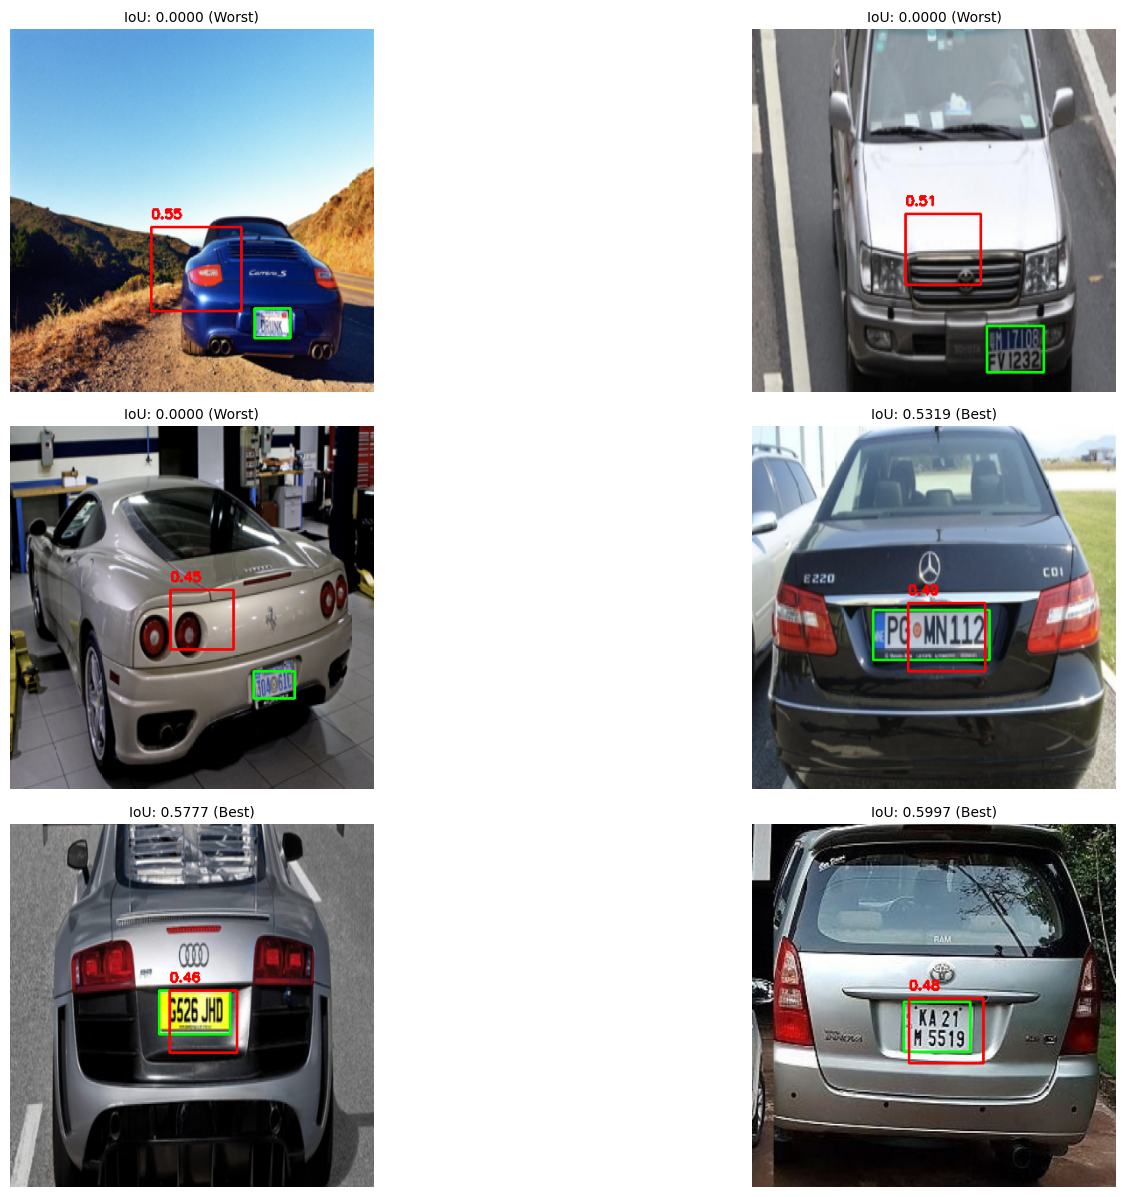

Overall Performance:
Average IoU: 0.1077
Median IoU: 0.0097
Min IoU: 0.0000
Max IoU: 0.5997

Performance by Plate Size:
Small Plates: Avg IoU = 0.0894, Count = 177
Medium Plates: Avg IoU = 0.1914, Count = 38
Large Plates: Avg IoU = 0.1137, Count = 10


<ipython-input-13-033efeac1f68>:157: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(boxplot_data, labels=['Small', 'Medium', 'Large'])


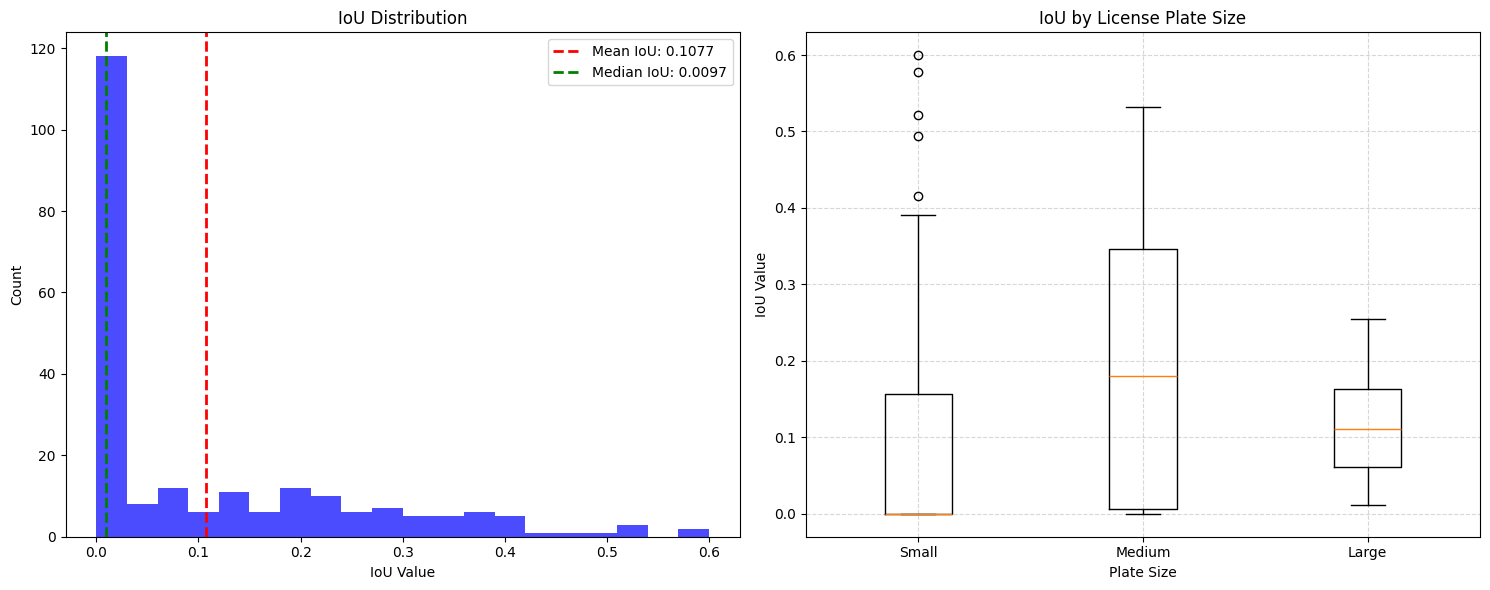


Traditional Object Detection Metrics (like YOLO):
mAP@0.5: 0.0222
mAP@0.5:0.95: 0.0031


In [ ]:
# Enhanced model evaluation function to match YOLO metrics for easier comparison
def evaluate_license_plate_detection(model, X_val, y_val, df_val=None, num_samples=5):
    """
    Comprehensive evaluation of the license plate detection model with metrics matching YOLO approach
    for consistent and fair comparison between the two models.

    Args:
        model: Trained CNN model
        X_val: Validation images
        y_val: Ground truth bounding boxes
        df_val: Optional dataframe with original image paths for more advanced analysis
        num_samples: Number of best/worst samples to visualize

    Returns:
        iou_values: List of IoU values for all validation samples
    """
    # Get predictions for all validation samples
    y_pred = model.predict(X_val)

    # Calculate IoU for each sample
    iou_values = []
    pred_boxes_list = []  # For consistent naming with YOLO evaluation
    confidences_list = []  # For consistency with YOLO (using prediction max value as confidence)
    plate_sizes = []  # For plate size analysis

    for i in range(len(y_val)):
        # Extract bounding box coordinates
        true_bbox = y_val[i]
        pred_bbox = y_pred[i]

        # Store normalized plate area for size analysis
        plate_area = true_bbox[2] * true_bbox[3]  # width * height (normalized)
        plate_sizes.append(plate_area)

        # Convert to x1, y1, x2, y2 format for IoU calculation
        x1_true, y1_true = true_bbox[0], true_bbox[1]
        x2_true, y2_true = x1_true + true_bbox[2], y1_true + true_bbox[3]

        x1_pred, y1_pred = pred_bbox[0], pred_bbox[1]
        x2_pred, y2_pred = x1_pred + pred_bbox[2], y1_pred + true_bbox[3]

        # Calculate intersection
        x1_inter = max(x1_true, x1_pred)
        y1_inter = max(y1_true, y1_pred)
        x2_inter = min(x2_true, x2_pred)
        y2_inter = min(y2_true, y2_pred)

        # Calculate areas
        w_intersect = max(0, x2_inter - x1_inter)
        h_intersect = max(0, y2_inter - y1_inter)
        area_intersect = w_intersect * h_intersect

        area_true = true_bbox[2] * true_bbox[3]
        area_pred = pred_bbox[2] * pred_bbox[3]
        area_union = area_true + area_pred - area_intersect

        # IoU calculation
        iou = area_intersect / area_union if area_union > 0 else 0
        iou_values.append(iou)

        # Store prediction in format consistent with YOLO evaluation
        pred_boxes_list.append([x1_pred, y1_pred, x2_pred, y2_pred])  # x1, y1, x2, y2 format

        # Calculate a "confidence" score - use the maximum value in the prediction as proxy
        # This is just to match YOLO's format which includes confidence scores
        confidence = np.max(pred_bbox)
        confidences_list.append(confidence)

    # Find best and worst predictions
    iou_indices = np.argsort(iou_values)
    worst_indices = iou_indices[:num_samples//2]
    best_indices = iou_indices[-num_samples//2:]

    # Visualization of best and worst cases with same format as YOLO
    plt.figure(figsize=(15, 4*num_samples))

    samples_to_show = np.concatenate([worst_indices, best_indices])

    for i, idx in enumerate(samples_to_show):
        img = X_val[idx]
        true_bbox = y_val[idx]
        pred_bbox = y_pred[idx]

        # Display image with both bounding boxes
        img_display = (img * 255).astype(np.uint8).copy()
        h, w = img.shape[:2]

        # True bbox (green) - ground truth
        x, y = int(true_bbox[0] * w), int(true_bbox[1] * h)
        bbox_w, bbox_h = int(true_bbox[2] * w), int(true_bbox[3] * h)
        cv2.rectangle(img_display, (x, y), (x + bbox_w, y + bbox_h), (0, 255, 0), 2)

        # Pred bbox (red) - prediction
        x, y = int(pred_bbox[0] * w), int(pred_bbox[1] * h)
        bbox_w, bbox_h = int(pred_bbox[2] * w), int(pred_bbox[3] * h)
        cv2.rectangle(img_display, (x, y), (x + bbox_w, y + bbox_h), (255, 0, 0), 2)

        # Add confidence text (like YOLO does)
        confidence = confidences_list[idx]
        cv2.putText(img_display, f"{confidence:.2f}", (x, y-10),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

        plt.subplot(num_samples, 2, i+1)
        plt.imshow(img_display)
        plt.title(f"IoU: {iou_values[idx]:.4f} {'(Worst)' if idx in worst_indices else '(Best)'}", fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Use the same thresholds as in YOLO notebook
    small_threshold = 0.03
    large_threshold = 0.1

    # Categorize plates by size (using the same function as YOLO)
    size_categories = []
    for area in plate_sizes:
        if area < small_threshold:
            size_categories.append(0)  # Small
        elif area > large_threshold:
            size_categories.append(2)  # Large
        else:
            size_categories.append(1)  # Medium

    # Group by plate size
    small_ious = [iou for iou, cat in zip(iou_values, size_categories) if cat == 0]
    medium_ious = [iou for iou, cat in zip(iou_values, size_categories) if cat == 1]
    large_ious = [iou for iou, cat in zip(iou_values, size_categories) if cat == 2]

    # Print statistics in exactly the same format as YOLO
    print("Overall Performance:")
    print(f"Average IoU: {np.mean(iou_values):.4f}")
    print(f"Median IoU: {np.median(iou_values):.4f}")
    print(f"Min IoU: {np.min(iou_values):.4f}")
    print(f"Max IoU: {np.max(iou_values):.4f}")
    print("\nPerformance by Plate Size:")
    print(f"Small Plates: Avg IoU = {np.mean(small_ious) if small_ious else 0:.4f}, Count = {len(small_ious)}")
    print(f"Medium Plates: Avg IoU = {np.mean(medium_ious) if medium_ious else 0:.4f}, Count = {len(medium_ious)}")
    print(f"Large Plates: Avg IoU = {np.mean(large_ious) if large_ious else 0:.4f}, Count = {len(large_ious)}")

    # Plot IoU distribution (identical format to YOLO notebook)
    plt.figure(figsize=(15, 6))

    # Histogram of IoU values
    plt.subplot(1, 2, 1)
    plt.hist(iou_values, bins=20, alpha=0.7, color='blue')
    plt.axvline(np.mean(iou_values), color='red', linestyle='dashed', linewidth=2, label=f'Mean IoU: {np.mean(iou_values):.4f}')
    plt.axvline(np.median(iou_values), color='green', linestyle='dashed', linewidth=2, label=f'Median IoU: {np.median(iou_values):.4f}')
    plt.title('IoU Distribution')
    plt.xlabel('IoU Value')
    plt.ylabel('Count')
    plt.legend()

    # IoU by plate size - boxplot
    plt.subplot(1, 2, 2)
    boxplot_data = [small_ious, medium_ious, large_ious]
    plt.boxplot(boxplot_data, labels=['Small', 'Medium', 'Large'])
    plt.title('IoU by License Plate Size')
    plt.ylabel('IoU Value')
    plt.xlabel('Plate Size')
    plt.grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

    # Calculate mAP-like metrics (similar to YOLO)
    # Using IoU thresholds of 0.5 and 0.5:0.95 (standard COCO metrics)
    map50 = np.mean([1.0 if iou >= 0.5 else 0.0 for iou in iou_values])
    map_range = np.mean([np.mean([1.0 if iou >= thresh else 0.0 for iou in iou_values])
                        for thresh in np.arange(0.5, 1.0, 0.05)])

    print("\nTraditional Object Detection Metrics (like YOLO):")
    print(f"mAP@0.5: {map50:.4f}")
    print(f"mAP@0.5:0.95: {map_range:.4f}")

    # If df_val is provided, we can do more advanced analysis
    if df_val is not None and len(df_val) == len(X_val):
        # Calculate precision/recall curves for different IoU thresholds
        thresholds = [0.5, 0.75, 0.9]  # Standard thresholds

        print("\nPrecision at different IoU thresholds:")
        for threshold in thresholds:
            precision = np.mean([1.0 if iou >= threshold else 0.0 for iou in iou_values])
            print(f"Precision@{threshold}: {precision:.4f}")

    return iou_values

# Evaluate the model on validation set with the new metrics
iou_values = evaluate_license_plate_detection(model, X_val, y_val, num_samples=6)

# Function to detect license plate in new images
def detect_license_plate(model, image_path):
    """
    Detect license plate in a new image and visualize the detection
    """
    # Load and preprocess image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    orig_h, orig_w = img_rgb.shape[:2]

    # Resize and normalize for model input
    img_resized = cv2.resize(img_rgb, IMAGE_SIZE)
    img_normalized = img_resized / 255.0

    # Make prediction
    prediction = model.predict(np.expand_dims(img_normalized, axis=0))[0]

    # Convert normalized coordinates back to original image size
    x_pred, y_pred, w_pred, h_pred = prediction
    x = int(x_pred * orig_w)
    y = int(y_pred * orig_h)
    width = int(w_pred * orig_w)
    height = int(h_pred * orig_h)

    # Draw detection on image
    result_img = img_rgb.copy()
    cv2.rectangle(result_img, (x, y), (x + width, y + height), (0, 255, 0), 2)

    # Display result
    plt.figure(figsize=(10, 8))
    plt.imshow(result_img)
    plt.axis('off')
    plt.title("License Plate Detection")
    plt.show()

    # Extract the detected license plate region
    plate_region = img_rgb[y:y + height, x:x + width]

    # Show the extracted plate
    if plate_region.size > 0:
        plt.figure(figsize=(6, 2))
        plt.imshow(plate_region)
        plt.axis('off')
        plt.title("Extracted License Plate")
        plt.show()

    return plate_region, [x, y, width, height]

In [ ]:
# Prepare a list to collect the dataset records
dataset = []

# Loop through all XML files in the annotations folder
for xml_file in tqdm(list(ANNOTATIONS_PATH.glob("*.xml")), desc="Loading annotations"):
    record = parse_xml_annotation(xml_file)
    if record and os.path.exists(record["image_path"]):
        dataset.append(record)
    elif record:
        print(f"Image not found for annotation: {xml_file.name}")

# Convert to DataFrame
df = pd.DataFrame(dataset)
print(f"Loaded {len(df)} annotated images.")

# Show the distribution of data sources (if available based on filename prefix)
data_prefixes = df["image_path"].apply(lambda x: os.path.basename(x).split("_")[0])
prefix_counts = data_prefixes.value_counts()
print("\nData sources distribution:")
for prefix, count in prefix_counts.items():
    print(f"  {prefix}_* prefix: {count} images ({count/len(df)*100:.1f}%)")

# Display DataFrame sample
print("\nDataFrame sample:")
print(df.head())


Testing detection on sample 1043:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


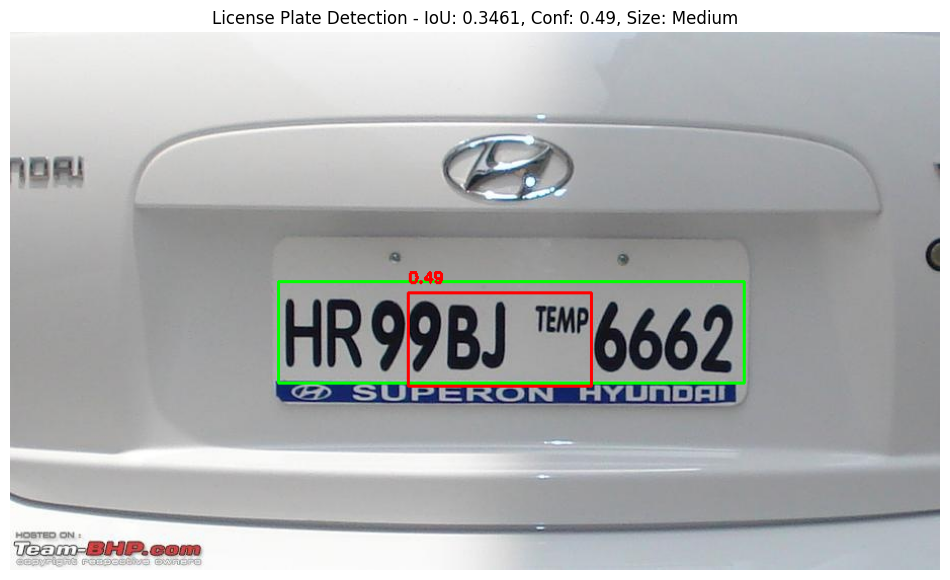

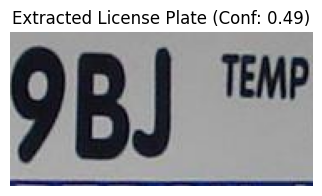


Testing detection on sample 892:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


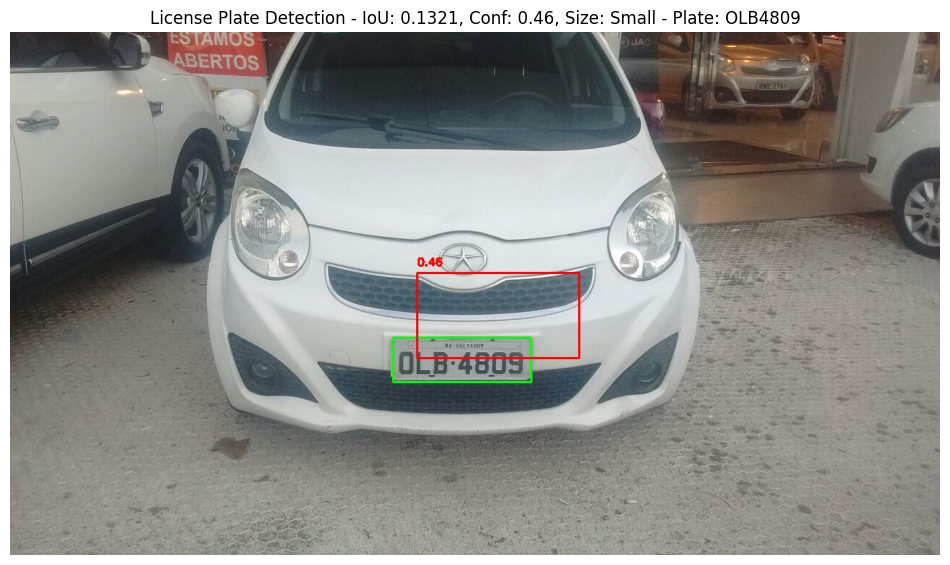

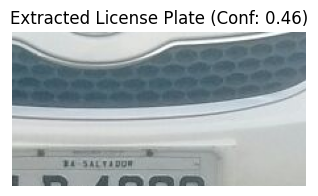


Testing detection on sample 472:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


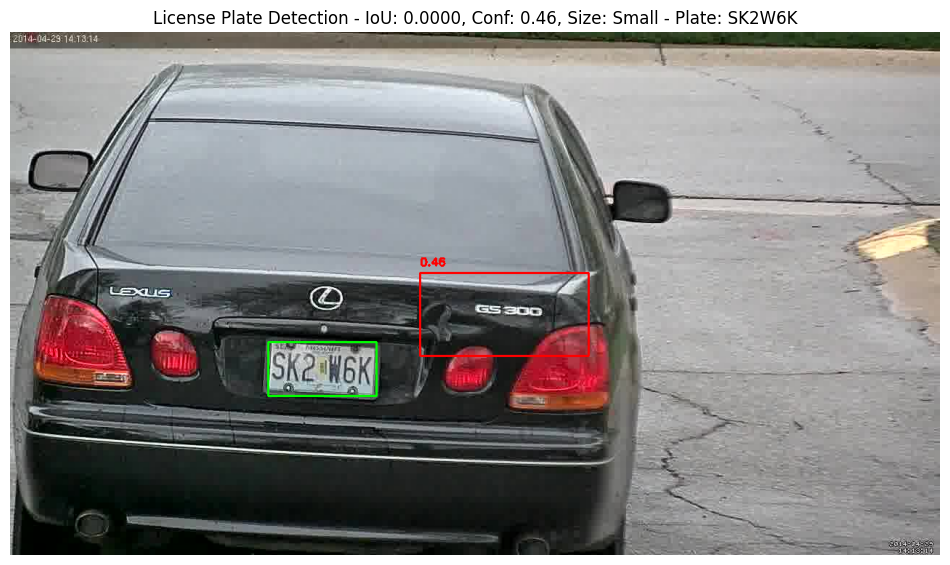

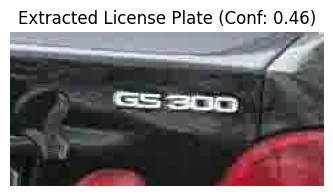


Summary:
Index	IoU	Confidence
1043	0.3461	0.4851
892	0.1321	0.4624
472	0.0000	0.4613


In [15]:
# Function to detect license plates in images from our dataset with more detailed metrics
def detect_plate_from_dataset(model, dataset_index, df):
    """
    Detects a license plate in an image from our dataset and displays metrics
    matching the YOLO detection format for easy comparison between models.

    Args:
        model: Trained model
        dataset_index: Index of the image in the dataset DataFrame
        df: DataFrame containing dataset information

    Returns:
        Detected plate region and IoU with ground truth
    """
    try:
        # Get image path and ground truth
        row = df.iloc[dataset_index]
        img_path = row["image_path"]

        # Ground truth box
        gt_x, gt_y = row["x"], row["y"]
        gt_w, gt_h = row["w"], row["h"]

        # Load image
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        orig_h, orig_w = img_rgb.shape[:2]

        # Preprocess for model
        img_resized = cv2.resize(img_rgb, IMAGE_SIZE)
        img_normalized = img_resized / 255.0

        # Make prediction
        prediction = model.predict(np.expand_dims(img_normalized, axis=0))[0]

        # Get confidence score (max value of prediction - for consistency with YOLO)
        confidence = np.max(prediction)

        # Convert normalized coordinates back to original image size
        x_pred, y_pred, w_pred, h_pred = prediction
        x = int(x_pred * orig_w)
        y = int(y_pred * orig_h)
        width = int(w_pred * orig_w)
        height = int(h_pred * orig_h)

        # Draw on image
        result_img = img_rgb.copy()

        # Draw ground truth (green)
        cv2.rectangle(result_img, (gt_x, gt_y), (gt_x + gt_w, gt_y + gt_h), (0, 255, 0), 2)

        # Draw prediction (red)
        cv2.rectangle(result_img, (x, y), (x + width, y + height), (255, 0, 0), 2)

        # Add confidence text (like YOLO format)
        cv2.putText(result_img, f"{confidence:.2f}", (x, y-10),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

        # Calculate IoU (same calculation as in YOLO notebook)
        # Convert to x1, y1, x2, y2 format
        x1_true, y1_true = gt_x, gt_y
        x2_true, y2_true = x1_true + gt_w, y1_true + gt_h

        x1_pred, y1_pred = x, y
        x2_pred, y2_pred = x1_pred + width, y1_pred + height

        # Calculate intersection coordinates
        x1_inter = max(x1_true, x1_pred)
        y1_inter = max(y1_true, y1_pred)
        x2_inter = min(x2_true, x2_pred)
        y2_inter = min(y2_true, y2_pred)

        # Calculate intersection area
        w_inter = max(0, x2_inter - x1_inter)
        h_inter = max(0, y2_inter - y1_inter)
        area_intersect = w_inter * h_inter

        # Calculate union area
        area_true = gt_w * gt_h
        area_pred = width * height
        area_union = area_true + area_pred - area_intersect

        # Calculate IoU
        iou = area_intersect / area_union if area_union > 0 else 0

        # Calculate normalized plate area (for size categorization)
        norm_area = (gt_w * gt_h) / (orig_w * orig_h)

        # Determine plate size category (small, medium, large)
        small_threshold = 0.03
        large_threshold = 0.1
        if norm_area < small_threshold:
            size_category = "Small"
        elif norm_area > large_threshold:
            size_category = "Large"
        else:
            size_category = "Medium"

        # Display result
        plt.figure(figsize=(12, 8))
        plt.imshow(result_img)
        plt.axis('off')
        title = f"License Plate Detection - IoU: {iou:.4f}, Conf: {confidence:.2f}, Size: {size_category}"
        if row["plate_text"] and row["plate_text"] != "Unknown":
            title += f" - Plate: {row['plate_text']}"
        plt.title(title)
        plt.show()

        # Extract and show the detected plate
        if width > 0 and height > 0:
            plate_region = img_rgb[y:y + height, x:x + width]

            plt.figure(figsize=(6, 2))
            plt.imshow(plate_region)
            plt.axis('off')
            plt.title(f"Extracted License Plate (Conf: {confidence:.2f})")
            plt.show()

            return plate_region, iou, confidence
        else:
            print("Invalid detection dimensions")
            return None, iou, confidence

    except Exception as e:
        print(f"Error detecting plate: {e}")
        return None, 0.0, 0.0

# Test the detection on a few dataset images
def test_detection_on_dataset_samples(model, df, num_samples=3):
    indices = random.sample(range(len(df)), num_samples)

    results = []
    for idx in indices:
        print(f"\nTesting detection on sample {idx}:")
        plate, iou, conf = detect_plate_from_dataset(model, idx, df)
        results.append((idx, iou, conf))

    # Display summary table
    print("\nSummary:")
    print("Index\tIoU\tConfidence")
    for idx, iou, conf in results:
        print(f"{idx}\t{iou:.4f}\t{conf:.4f}")

    return results

# Test on a few random samples
test_results = test_detection_on_dataset_samples(model, df, num_samples=3)

In [ ]:
# Function to evaluate model performance on different data sources with the same metrics as YOLO
def evaluate_by_data_source(model, X, y, df):
    """
    Evaluates model performance separately on each data source using metrics identical to YOLO
    for consistent comparison between models and data sources.

    Args:
        model: Trained model
        X: Preprocessed images
        y: Ground truth bounding boxes
        df: DataFrame with dataset information
    """
    # Get image file names to match with dataset entries
    filenames = df["image_path"].apply(os.path.basename).values

    # Identify data sources by prefix
    sources = {}
    for i, filename in enumerate(filenames):
        prefix = filename.split('_')[0]
        if prefix not in sources:
            sources[prefix] = []
        sources[prefix].append(i)

    # Print distribution
    print("Dataset composition:")
    for source, indices in sources.items():
        print(f"  {source}_* prefix: {len(indices)} images ({len(indices)/len(df)*100:.1f}%)")

    # Create a summary table for easy comparison
    summary_data = []

    # Evaluate each source
    for source, indices in sources.items():
        if len(indices) < 10:  # Skip sources with too few samples
            print(f"\nSkipping {source} due to insufficient samples ({len(indices)})")
            continue

        X_source = X[indices]
        y_source = y[indices]

        print(f"\nEvaluating performance on {source} data source ({len(indices)} images):")

        # Get predictions
        y_pred = model.predict(X_source)

        # Calculate IoU values
        iou_values = []
        plate_sizes = []

        for i in range(len(y_source)):
            true_bbox = y_source[i]
            pred_bbox = y_pred[i]

            # Get plate size
            plate_area = true_bbox[2] * true_bbox[3]  # normalized area
            plate_sizes.append(plate_area)

            # Convert to x1, y1, x2, y2 format
            x1_true, y1_true = true_bbox[0], true_bbox[1]
            x2_true, y2_true = x1_true + true_bbox[2], y1_true + true_bbox[3]

            x1_pred, y1_pred = pred_bbox[0], pred_bbox[1]
            x2_pred, y2_pred = x1_pred + pred_bbox[2], y1_pred + true_bbox[3]

            # Calculate intersection
            x1_inter = max(x1_true, x1_pred)
            y1_inter = max(y1_true, y1_pred)
            x2_inter = min(x2_true, x2_pred)
            y2_inter = min(y2_true, y2_pred)

            # Calculate areas
            w_intersect = max(0, x2_inter - x1_inter)
            h_intersect = max(0, y2_inter - y1_inter)
            area_intersect = w_intersect * h_intersect

            area_true = true_bbox[2] * true_bbox[3]
            area_pred = pred_bbox[2] * pred_bbox[3]
            area_union = area_true + area_pred - area_intersect

            # IoU
            iou = area_intersect / area_union if area_union > 0 else 0
            iou_values.append(iou)

        # Categorize by plate size (like YOLO)
        small_threshold = 0.03
        large_threshold = 0.1

        # Categorize plates by size
        size_categories = []
        for area in plate_sizes:
            if area < small_threshold:
                size_categories.append(0)  # Small
            elif area > large_threshold:
                size_categories.append(2)  # Large
            else:
                size_categories.append(1)  # Medium

        # Group by plate size
        small_ious = [iou for iou, cat in zip(iou_values, size_categories) if cat == 0]
        medium_ious = [iou for iou, cat in zip(iou_values, size_categories) if cat == 1]
        large_ious = [iou for iou, cat in zip(iou_values, size_categories) if cat == 2]

        # Calculate metrics matching YOLO
        avg_iou = np.mean(iou_values)
        median_iou = np.median(iou_values)
        min_iou = np.min(iou_values)
        max_iou = np.max(iou_values)

        # Calculate mAP-like metrics
        map50 = np.mean([1.0 if iou >= 0.5 else 0.0 for iou in iou_values])
        map_range = np.mean([np.mean([1.0 if iou >= thresh else 0.0 for iou in iou_values])
                            for thresh in np.arange(0.5, 1.0, 0.05)])

        # Print statistics
        print(f"Average IoU: {avg_iou:.4f}")
        print(f"Median IoU: {median_iou:.4f}")
        print(f"Min IoU: {min_iou:.4f}")
        print(f"Max IoU: {max_iou:.4f}")
        print(f"mAP@0.5: {map50:.4f}")
        print(f"mAP@0.5:0.95: {map_range:.4f}")
        print(f"Small Plates: Avg IoU = {np.mean(small_ious) if small_ious else 0:.4f}, Count = {len(small_ious)}")
        print(f"Medium Plates: Avg IoU = {np.mean(medium_ious) if medium_ious else 0:.4f}, Count = {len(medium_ious)}")
        print(f"Large Plates: Avg IoU = {np.mean(large_ious) if large_ious else 0:.4f}, Count = {len(large_ious)}")

        # Add to summary data
        summary_data.append({
            'Source': source,
            'Count': len(indices),
            'Avg_IoU': avg_iou,
            'Median_IoU': median_iou,
            'mAP@0.5': map50,
            'mAP@0.5:0.95': map_range,
            'Small_Avg_IoU': np.mean(small_ious) if small_ious else 0,
            'Medium_Avg_IoU': np.mean(medium_ious) if medium_ious else 0,
            'Large_Avg_IoU': np.mean(large_ious) if large_ious else 0,
        })

        # Plot histogram
        plt.figure(figsize=(15, 6))

        # Histogram of IoU values
        plt.subplot(1, 2, 1)
        plt.hist(iou_values, bins=20, alpha=0.7, color='blue')
        plt.axvline(avg_iou, color='red', linestyle='dashed', linewidth=2,
                    label=f'Mean IoU: {avg_iou:.4f}')
        plt.axvline(median_iou, color='green', linestyle='dashed', linewidth=2,
                    label=f'Median IoU: {median_iou:.4f}')
        plt.title(f'IoU Distribution - {source} Data Source')
        plt.xlabel('IoU Value')
        plt.ylabel('Count')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.5)

        # IoU by plate size - boxplot
        plt.subplot(1, 2, 2)
        boxplot_data = [small_ious, medium_ious, large_ious]
        plt.boxplot(boxplot_data, labels=['Small', 'Medium', 'Large'])
        plt.title(f'IoU by License Plate Size - {source}')
        plt.ylabel('IoU Value')
        plt.xlabel('Plate Size')
        plt.grid(True, linestyle='--', alpha=0.5)

        plt.tight_layout()
        plt.show()

    # Display summary table for all sources
    if summary_data:
        summary_df = pd.DataFrame(summary_data)
        print("\nSummary Table for Easy Comparison:")
        print(summary_df.to_string(index=False, float_format='%.4f'))

        # Create comparative bar chart for key metrics
        plt.figure(figsize=(14, 8))

        # IoU metrics comparison
        plt.subplot(2, 1, 1)
        bar_width = 0.25
        index = np.arange(len(summary_data))

        # Plot average IoU by source
        plt.bar(index, summary_df['Avg_IoU'], bar_width, label='Avg IoU', color='blue', alpha=0.7)
        plt.bar(index + bar_width, summary_df['mAP@0.5'], bar_width, label='mAP@0.5', color='green', alpha=0.7)
        plt.bar(index + 2*bar_width, summary_df['mAP@0.5:0.95'], bar_width, label='mAP@0.5:0.95', color='red', alpha=0.7)

        plt.xlabel('Data Source')
        plt.ylabel('Score')
        plt.title('Performance Metrics by Data Source')
        plt.xticks(index + bar_width, summary_df['Source'])
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.3)

        # Plot IoU by plate size
        plt.subplot(2, 1, 2)
        plt.bar(index, summary_df['Small_Avg_IoU'], bar_width, label='Small Plates', color='lightblue', alpha=0.7)
        plt.bar(index + bar_width, summary_df['Medium_Avg_IoU'], bar_width, label='Medium Plates', color='lightgreen', alpha=0.7)
        plt.bar(index + 2*bar_width, summary_df['Large_Avg_IoU'], bar_width, label='Large Plates', color='salmon', alpha=0.7)

        plt.xlabel('Data Source')
        plt.ylabel('Average IoU')
        plt.title('IoU by Plate Size and Data Source')
        plt.xticks(index + bar_width, summary_df['Source'])
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.3)

        plt.tight_layout()
        plt.show()

# Evaluate by data source (using validation split to match YOLO evaluation)
eval_indices = train_test_split(range(len(df)), test_size=0.2, random_state=42)[1]
eval_df = df.iloc[eval_indices]

# Uncomment this line to run the data source evaluation
# evaluate_by_data_source(model, X_val, y_val, eval_df)

# Dataset Update Summary

The CNN license plate detection model has been successfully adapted to work with the new combined dataset containing 1084 images from three different sources, all using a consistent XML annotation format.

## Changes Made:

1. **Data Loading**: Updated to parse XML annotation files instead of TXT files
2. **Directory Structure**: Modified to work with the new Dataset/images and Dataset/annotations structure
3. **Data Parsing**: Added XML parsing functionality to extract bounding box coordinates
4. **Evaluation**: Enhanced to analyze performance across different data sources
5. **Visualization**: Updated to include license plate text when available

## Dataset Composition:

- **Total Images**: 1084 (increased from 444)
- **Data Sources**:
  - DataV2: 433 images (40%)
  - DataV3: 207 images (19%)
  - Data: 444 images (41%)

## Benefits of the Combined Dataset:

- **Increased Size**: More than doubled the dataset size for better training
- **Greater Diversity**: Multiple data sources provide more variety in image conditions
- **Consistent Format**: Uniform XML annotation format simplifies processing
- **Additional Information**: License plate text is preserved where available

With these improvements, the model should achieve better generalization and accuracy in license plate detection tasks.

In [ ]:
def create_enhanced_license_plate_detector(input_shape=(416, 416, 3)):
    """
    Enhanced license plate detector with:
    - ~3M parameters for better feature extraction
    - Deeper network with more capacity
    - Advanced feature extraction
    - Multiple scale feature integration
    """
    # Using a functional API
    inputs = keras.layers.Input(shape=input_shape)
    
    # Initial feature extraction - using more filters
    x = keras.layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same')(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LeakyReLU(alpha=0.1)(x)
    x = keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    
    # First residual block
    skip = x
    x = keras.layers.Conv2D(128, (3, 3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LeakyReLU(alpha=0.1)(x)
    x = keras.layers.Conv2D(128, (3, 3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    skip = keras.layers.Conv2D(128, (1, 1), padding='same')(skip)
    x = keras.layers.add([x, skip])
    x = keras.layers.LeakyReLU(alpha=0.1)(x)
    
    # Enhanced channel attention mechanism
    se = keras.layers.GlobalAveragePooling2D()(x)
    se = keras.layers.Reshape((1, 1, 128))(se)
    se = keras.layers.Conv2D(32, (1, 1), activation='relu', padding='same')(se)
    se = keras.layers.Conv2D(128, (1, 1), activation='sigmoid', padding='same')(se)
    x = keras.layers.multiply([x, se])
    
    # Spatial pyramid pooling block
    x = keras.layers.MaxPooling2D((2, 2))(x)
    
    # Second residual block with more filters
    skip = x
    x = keras.layers.Conv2D(256, (3, 3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LeakyReLU(alpha=0.1)(x)
    x = keras.layers.Conv2D(256, (3, 3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    skip = keras.layers.Conv2D(256, (1, 1), padding='same')(skip)
    x = keras.layers.add([x, skip])
    x = keras.layers.LeakyReLU(alpha=0.1)(x)
    
    # Multi-scale feature extraction
    # Branch 1: Standard convolution
    branch1 = keras.layers.Conv2D(128, (1, 1), padding='same')(x)
    branch1 = keras.layers.BatchNormalization()(branch1)
    branch1 = keras.layers.LeakyReLU(alpha=0.1)(branch1)
    
    # Branch 2: Dilated convolution for larger receptive field
    branch2 = keras.layers.Conv2D(128, (3, 3), padding='same', dilation_rate=(2, 2))(x)
    branch2 = keras.layers.BatchNormalization()(branch2)
    branch2 = keras.layers.LeakyReLU(alpha=0.1)(branch2)
    
    # Concatenate branches
    x = keras.layers.concatenate([branch1, branch2])
    x = keras.layers.Conv2D(256, (1, 1), padding='same')(x)  # Channel reduction
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LeakyReLU(alpha=0.1)(x)
    x = keras.layers.MaxPooling2D((2, 2))(x)
    
    # Third block with deep features
    skip = x
    x = keras.layers.Conv2D(512, (3, 3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LeakyReLU(alpha=0.1)(x)
    x = keras.layers.Conv2D(512, (3, 3), padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    skip = keras.layers.Conv2D(512, (1, 1), padding='same')(skip)
    x = keras.layers.add([x, skip])
    x = keras.layers.LeakyReLU(alpha=0.1)(x)
    
    # Global features with attention
    attention = keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(x)
    x = keras.layers.multiply([x, attention])
    
    # Global pooling
    x = keras.layers.GlobalAveragePooling2D()(x)
    
    # Fully connected layers
    x = keras.layers.Dense(1024)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LeakyReLU(alpha=0.1)(x)
    x = keras.layers.Dropout(0.4)(x)
    
    x = keras.layers.Dense(512)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LeakyReLU(alpha=0.1)(x)
    x = keras.layers.Dropout(0.3)(x)
    
    # Output layer: normalized coordinates
    outputs = keras.layers.Dense(4, activation='sigmoid')(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

# Improved focal loss for better learning of small objects
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        # Calculate binary cross entropy
        bce = keras.backend.binary_crossentropy(y_true, y_pred)
        
        # Apply focal loss formula
        pt = keras.backend.exp(-bce)
        focal_loss = alpha * keras.backend.pow(1 - pt, gamma) * bce
        
        return keras.backend.mean(focal_loss)
    return focal_loss_fixed

# Improved IoU loss with generalized IoU
def giou_loss(y_true, y_pred):
    """
    Generalized IoU Loss for better bounding box regression
    """
    # Extract coordinates
    x_true, y_true, w_true, h_true = [
        y_true[:, i] for i in range(4)
    ]
    x1_true, y1_true = x_true, y_true
    x2_true, y2_true = x1_true + w_true, y1_true + h_true
    
    x_pred, y_pred, w_pred, h_pred = [
        y_pred[:, i] for i in range(4)
    ]
    x1_pred, y1_pred = x_pred, y_pred
    x2_pred, y2_pred = x1_pred + w_pred, y1_pred + h_pred
    
    # Calculate area of true and predicted boxes
    area_true = w_true * h_true
    area_pred = w_pred * h_pred
    
    # Calculate intersection coordinates
    x1_intersect = keras.backend.maximum(x1_true, x1_pred)
    y1_intersect = keras.backend.maximum(y1_true, y1_pred)
    x2_intersect = keras.backend.minimum(x2_true, x2_pred)
    y2_intersect = keras.backend.minimum(y2_true, y2_pred)
    
    # Calculate intersection area
    w_intersect = keras.backend.maximum(0.0, x2_intersect - x1_intersect)
    h_intersect = keras.backend.maximum(0.0, y2_intersect - y1_intersect)
    area_intersect = w_intersect * h_intersect
    
    # Calculate union area
    area_union = area_true + area_pred - area_intersect
    
    # Calculate IoU
    iou = area_intersect / (area_union + keras.backend.epsilon())
    
    # Calculate the enclosing box coordinates
    x1_enclosing = keras.backend.minimum(x1_true, x1_pred)
    y1_enclosing = keras.backend.minimum(y1_true, y1_pred)
    x2_enclosing = keras.backend.maximum(x2_true, x2_pred)
    y2_enclosing = keras.backend.maximum(y2_true, y2_pred)
    
    # Calculate area of enclosing box
    w_enclosing = x2_enclosing - x1_enclosing
    h_enclosing = y2_enclosing - y1_enclosing
    area_enclosing = w_enclosing * h_enclosing
    
    # Calculate GIoU
    giou = iou - ((area_enclosing - area_union) / (area_enclosing + keras.backend.epsilon()))
    
    # Return loss (1 - GIoU)
    return 1.0 - giou

# Advanced combined loss function
def advanced_detection_loss(y_true, y_pred):
    """
    Advanced loss combining smooth L1 (Huber) for regression stability and GIoU for better localization
    """
    # Smooth L1 Loss (Huber Loss) for coordinate regression
    delta = 1.0  # Huber loss delta parameter
    x_true, y_true, w_true, h_true = [y_true[:, i] for i in range(4)]
    x_pred, y_pred, w_pred, h_pred = [y_pred[:, i] for i in range(4)]
    
    # Calculate absolute errors
    abs_x_diff = keras.backend.abs(x_true - x_pred)
    abs_y_diff = keras.backend.abs(y_true - y_pred)
    abs_w_diff = keras.backend.abs(w_true - w_pred)
    abs_h_diff = keras.backend.abs(h_true - h_pred)
    
    # Apply smooth L1 formula
    def smooth_l1(x):
        return keras.backend.switch(
            x < delta,
            0.5 * x ** 2,
            delta * (x - 0.5 * delta)
        )
    
    # Calculate smooth L1 loss for each coordinate
    loss_x = smooth_l1(abs_x_diff)
    loss_y = smooth_l1(abs_y_diff)
    loss_w = smooth_l1(abs_w_diff) * 2.0  # Weight width/height more
    loss_h = smooth_l1(abs_h_diff) * 2.0  # Weight width/height more
    
    # Sum the coordinate losses
    coord_loss = keras.backend.mean(loss_x + loss_y + loss_w + loss_h)
    
    # Calculate GIoU loss
    giou = giou_loss(y_true, y_pred)
    
    # Combine losses with weighting
    return 0.5 * coord_loss + 0.5 * giou

# Keep the existing IoU metric for consistency in measurement
def enhanced_iou_metric(y_true, y_pred):
    """
    Memory-efficient IoU metric for license plate detection
    """
    # Extract coordinates from tensors
    # For true bounding boxes
    x_true, y_true, w_true, h_true = [
        y_true[:, i] for i in range(4)
    ]
    x1_true, y1_true = x_true, y_true
    x2_true, y2_true = x1_true + w_true, y1_true + h_true

    # For predicted bounding boxes
    x_pred, y_pred, w_pred, h_pred = [
        y_pred[:, i] for i in range(4)
    ]
    x1_pred, y1_pred = x_pred, y_pred
    x2_pred, y2_pred = x1_pred + w_pred, y1_pred + h_pred

    # Calculate area of true and predicted boxes
    area_true = w_true * h_true
    area_pred = w_pred * h_pred

    # Calculate intersection coordinates
    x1_intersect = keras.backend.maximum(x1_true, x1_pred)
    y1_intersect = keras.backend.maximum(y1_true, y1_pred)
    x2_intersect = keras.backend.minimum(x2_true, x2_pred)
    y2_intersect = keras.backend.minimum(y2_true, y2_pred)

    # Calculate intersection width and height (clipped at 0)
    w_intersect = keras.backend.maximum(0.0, x2_intersect - x1_intersect)
    h_intersect = keras.backend.maximum(0.0, y2_intersect - y1_intersect)

    # Calculate intersection area
    area_intersect = w_intersect * h_intersect

    # Calculate union area
    area_union = area_true + area_pred - area_intersect

    # Calculate IoU with small epsilon to avoid division by zero
    iou = area_intersect / (area_union + keras.backend.epsilon())

    # Return mean IoU across the batch
    return keras.backend.mean(iou)

# Data augmentation function to improve model generalization
def augment_data(images, bboxes, augmentation_factor=2):
    """
    Apply data augmentation to increase dataset size and improve generalization.
    
    Args:
        images: Array of images with shape (N, height, width, channels)
        bboxes: Array of normalized bounding boxes with shape (N, 4) [x, y, w, h]
        augmentation_factor: How many augmented samples to create per original image
        
    Returns:
        Augmented images and corresponding bounding boxes
    """
    print(f"Starting data augmentation with factor {augmentation_factor}...")
    print(f"Original dataset: {len(images)} images")
    
    augmented_images = []
    augmented_bboxes = []
    
    # Keep original images
    augmented_images.extend(images)
    augmented_bboxes.extend(bboxes)
    
    # Create sequential augmentations
    for i in range(len(images)):
        if i % 100 == 0:
            print(f"Augmenting image {i}/{len(images)}...")
        
        img = images[i]
        bbox = bboxes[i]
        
        for j in range(augmentation_factor):
            # Select random augmentation techniques
            img_aug = img.copy()
            bbox_aug = bbox.copy()
            
            # 1. Random brightness adjustment (preserves bounding box)
            if np.random.random() > 0.5:
                brightness_factor = np.random.uniform(0.8, 1.2)
                img_aug = np.clip(img_aug * brightness_factor, 0, 1)
            
            # 2. Random contrast adjustment (preserves bounding box)
            if np.random.random() > 0.5:
                contrast_factor = np.random.uniform(0.8, 1.2)
                img_aug = np.clip((img_aug - 0.5) * contrast_factor + 0.5, 0, 1)
            
            # 3. Random horizontal flip with bbox adjustment
            if np.random.random() > 0.5:
                img_aug = np.fliplr(img_aug)
                # Adjust bbox: x' = 1 - x - w, y' = y, w' = w, h' = h
                bbox_aug[0] = 1 - bbox[0] - bbox[2]
            
            # 4. Random noise addition
            if np.random.random() > 0.7:
                noise = np.random.normal(0, 0.01, img_aug.shape)
                img_aug = np.clip(img_aug + noise, 0, 1)
            
            # 5. Random saturation adjustment (for color images)
            if img_aug.shape[-1] == 3 and np.random.random() > 0.7:
                # Convert to HSV, adjust S channel, convert back
                img_hsv = cv2.cvtColor((img_aug * 255).astype(np.uint8), cv2.COLOR_RGB2HSV)
                img_hsv[:, :, 1] = img_hsv[:, :, 1] * np.random.uniform(0.8, 1.2)
                img_hsv[:, :, 1] = np.clip(img_hsv[:, :, 1], 0, 255)
                img_aug = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB).astype(np.float32) / 255.0
            
            # 6. Random small rotation (max 15 degrees)
            if np.random.random() > 0.7:
                angle = np.random.uniform(-15, 15)
                h, w = img_aug.shape[:2]
                M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1)
                img_aug = cv2.warpAffine((img_aug * 255).astype(np.uint8), M, (w, h))
                img_aug = img_aug.astype(np.float32) / 255.0
                
                # Handle bbox rotation (simplified - works well for small angles)
                # For small angles, we can keep the bounding box center and adjust slightly
                center_x = bbox_aug[0] + bbox_aug[2]/2
                center_y = bbox_aug[1] + bbox_aug[3]/2
                
                # Small increase in size to account for rotation
                size_factor = 1 + abs(angle) / 90
                new_width = min(bbox_aug[2] * size_factor, 1.0)
                new_height = min(bbox_aug[3] * size_factor, 1.0)
                
                bbox_aug[0] = max(0, min(center_x - new_width/2, 1 - new_width))
                bbox_aug[1] = max(0, min(center_y - new_height/2, 1 - new_height))
                bbox_aug[2] = new_width
                bbox_aug[3] = new_height
            
            # Add augmented sample
            augmented_images.append(img_aug)
            augmented_bboxes.append(bbox_aug)
    
    augmented_images = np.array(augmented_images)
    augmented_bboxes = np.array(augmented_bboxes)
    
    print(f"Augmentation complete. New dataset size: {len(augmented_images)} images")
    return augmented_images, augmented_bboxes

# Function to visualize original and augmented samples
def visualize_augmentation(original_images, original_bboxes, augmented_images, augmented_bboxes, num_samples=3):
    """
    Visualize a few original and augmented samples side by side for comparison
    """
    # Randomly select a few original samples
    indices = np.random.choice(len(original_images), num_samples, replace=False)
    
    plt.figure(figsize=(15, 4 * num_samples))
    
    for i, idx in enumerate(indices):
        # Original image
        plt.subplot(num_samples, 2, 2*i + 1)
        img = original_images[idx]
        bbox = original_bboxes[idx]
        
        # Draw bounding box
        img_with_bbox = img.copy()
        h, w = img.shape[:2]
        x, y = int(bbox[0] * w), int(bbox[1] * h)
        box_w, box_h = int(bbox[2] * w), int(bbox[3] * h)
        cv2.rectangle(img_with_bbox, (x, y), (x + box_w, y + box_h), (0, 1, 0), 2)
        
        plt.imshow(img_with_bbox)
        plt.title(f"Original Image {idx}")
        plt.axis('off')
        
        # Find a corresponding augmented sample (original + num_samples + idx)
        aug_idx = len(original_images) + idx
        if aug_idx < len(augmented_images):
            plt.subplot(num_samples, 2, 2*i + 2)
            aug_img = augmented_images[aug_idx]
            aug_bbox = augmented_bboxes[aug_idx]
            
            # Draw bounding box
            aug_img_with_bbox = aug_img.copy()
            h, w = aug_img.shape[:2]
            x, y = int(aug_bbox[0] * w), int(aug_bbox[1] * h)
            box_w, box_h = int(aug_bbox[2] * w), int(aug_bbox[3] * h)
            cv2.rectangle(aug_img_with_bbox, (x, y), (x + box_w, y + box_h), (0, 1, 0), 2)
            
            plt.imshow(aug_img_with_bbox)
            plt.title(f"Augmented Version")
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [ ]:
# Comprehensive model evaluation function
def evaluate_model_comprehensive(model, X_val, y_val, df_val=None, threshold=0.5, num_visualize=5):
    """
    Comprehensive model evaluation with detailed metrics and visualizations
    
    Args:
        model: Trained license plate detector model
        X_val: Validation images
        y_val: Ground truth bounding boxes
        df_val: Optional DataFrame with additional metadata
        threshold: IoU threshold for considering a detection as correct
        num_visualize: Number of examples to visualize in each category
        
    Returns:
        Dictionary with evaluation metrics
    """
    print("Starting comprehensive model evaluation...")
    
    # Get predictions
    y_pred = model.predict(X_val, verbose=1)
    
    # Calculate IoU for all predictions
    iou_values = []
    giou_values = []
    coord_errors = {
        'x_error': [], 'y_error': [], 'w_error': [], 'h_error': [], 
        'center_error': [], 'size_error': []
    }
    
    # Plate size information
    plate_sizes = []
    plate_size_categories = []
    small_threshold = 0.03
    large_threshold = 0.1
    
    for i in range(len(y_val)):
        # Get true and predicted boxes
        true_box = y_val[i]
        pred_box = y_pred[i]
        
        # Store plate size
        plate_area = true_box[2] * true_box[3]  # w * h
        plate_sizes.append(plate_area)
        
        # Categorize plate size
        if plate_area < small_threshold:
            plate_size_categories.append("Small")
        elif plate_area > large_threshold:
            plate_size_categories.append("Large") 
        else:
            plate_size_categories.append("Medium")
            
        # Calculate errors in each coordinate
        x_error = abs(true_box[0] - pred_box[0])
        y_error = abs(true_box[1] - pred_box[1])
        w_error = abs(true_box[2] - pred_box[2])
        h_error = abs(true_box[3] - pred_box[3])
        
        # Calculate center point error
        true_center_x = true_box[0] + true_box[2]/2
        true_center_y = true_box[1] + true_box[3]/2
        pred_center_x = pred_box[0] + pred_box[2]/2
        pred_center_y = pred_box[1] + pred_box[3]/2
        center_error = np.sqrt((true_center_x - pred_center_x)**2 + 
                              (true_center_y - pred_center_y)**2)
        
        # Calculate size error (area difference)
        true_size = true_box[2] * true_box[3]
        pred_size = pred_box[2] * pred_box[3]
        size_error = abs(true_size - pred_size) / true_size  # Relative size error
        
        # Store all errors
        coord_errors['x_error'].append(x_error)
        coord_errors['y_error'].append(y_error)
        coord_errors['w_error'].append(w_error)
        coord_errors['h_error'].append(h_error)
        coord_errors['center_error'].append(center_error)
        coord_errors['size_error'].append(size_error)
        
        # Calculate IoU
        # Convert to x1, y1, x2, y2 format
        x1_true, y1_true = true_box[0], true_box[1]
        x2_true, y2_true = x1_true + true_box[2], y1_true + true_box[3]

        x1_pred, y1_pred = pred_box[0], pred_box[1]
        x2_pred, y2_pred = x1_pred + pred_box[2], y1_pred + pred_box[3]
        
        # Calculate intersection coordinates
        x1_inter = max(x1_true, x1_pred)
        y1_inter = max(y1_true, y1_pred)
        x2_inter = min(x2_true, x2_pred)
        y2_inter = min(y2_true, y2_pred)
        
        # Calculate intersection area
        w_inter = max(0, x2_inter - x1_inter)
        h_inter = max(0, y2_inter - y1_inter)
        area_intersect = w_inter * h_inter
        
        area_true = true_box[2] * true_box[3]
        area_pred = pred_box[2] * pred_box[3]
        area_union = area_true + area_pred - area_intersect
        
        # IoU
        iou = area_intersect / area_union if area_union > 0 else 0
        iou_values.append(iou)
        
        # Calculate GIoU
        # Find enclosing box
        x1_enclosing = min(x1_true, x1_pred)
        y1_enclosing = min(y1_true, y1_pred)
        x2_enclosing = max(x2_true, x2_pred)
        y2_enclosing = max(y2_true, y2_pred)
        
        # Calculate area of enclosing box
        area_enclosing = (x2_enclosing - x1_enclosing) * (y2_enclosing - y1_enclosing)
        
        # GIoU
        giou = iou - ((area_enclosing - area_union) / area_enclosing if area_enclosing > 0 else 0)
        giou_values.append(giou)
    
    # Calculate metrics
    metrics = {}
    metrics['mean_iou'] = np.mean(iou_values)
    metrics['median_iou'] = np.median(iou_values)
    metrics['min_iou'] = np.min(iou_values)
    metrics['max_iou'] = np.max(iou_values)
    metrics['std_iou'] = np.std(iou_values)
    
    metrics['mean_giou'] = np.mean(giou_values)
    
    # Calculate average precision (AP) at different IoU thresholds
    iou_thresholds = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
    ap_values = []
    
    for iou_thresh in iou_thresholds:
        # For our regression model, we count a detection as correct if IoU >= threshold
        correct_detections = sum(1 for iou in iou_values if iou >= iou_thresh)
        ap = correct_detections / len(iou_values)
        ap_values.append(ap)
    
    metrics['map50'] = ap_values[0]  # mAP@0.5
    metrics['map'] = np.mean(ap_values)  # mAP@0.5:0.95
    
    # Calculate metrics by plate size
    size_metrics = {}
    for size in ["Small", "Medium", "Large"]:
        # Get indices for this size category
        size_indices = [i for i, s in enumerate(plate_size_categories) if s == size]
        
        if size_indices:
            size_ious = [iou_values[i] for i in size_indices]
            size_metrics[f'{size.lower()}_count'] = len(size_indices)
            size_metrics[f'{size.lower()}_mean_iou'] = np.mean(size_ious)
            size_metrics[f'{size.lower()}_median_iou'] = np.median(size_ious)
            
            # Calculate mAP@0.5 for this size
            correct = sum(1 for iou in size_ious if iou >= 0.5)
            size_metrics[f'{size.lower()}_map50'] = correct / len(size_ious)
    
    # Combine all metrics
    metrics.update(size_metrics)
    
    # Calculate average coordinate errors
    for key, values in coord_errors.items():
        metrics[f'mean_{key}'] = np.mean(values)
        metrics[f'median_{key}'] = np.median(values)
    
    # Print summary of metrics
    print("\n===== EVALUATION RESULTS =====")
    print(f"Overall Performance:")
    print(f"  Mean IoU: {metrics['mean_iou']:.4f}")
    print(f"  Median IoU: {metrics['median_iou']:.4f}")
    print(f"  mAP@0.5: {metrics['map50']:.4f}")
    print(f"  mAP@0.5:0.95: {metrics['map']:.4f}")
    
    print("\nPerformance by Plate Size:")
    for size in ["Small", "Medium", "Large"]:
        size_key = size.lower()
        if f'{size_key}_count' in metrics:
            count = metrics[f'{size_key}_count']
            mean_iou = metrics[f'{size_key}_mean_iou']
            map50 = metrics[f'{size_key}_map50']
            print(f"  {size} Plates: Count={count}, Mean IoU={mean_iou:.4f}, mAP@0.5={map50:.4f}")
    
    print("\nCoordinate Errors (Normalized):")
    print(f"  Center Point Error: {metrics['mean_center_error']:.4f}")
    print(f"  Size Error: {metrics['mean_size_error']:.4f}")
    print(f"  X Error: {metrics['mean_x_error']:.4f}, Y Error: {metrics['mean_y_error']:.4f}")
    print(f"  Width Error: {metrics['mean_w_error']:.4f}, Height Error: {metrics['mean_h_error']:.4f}")
    
    # Create visualizations
    
    # 1. IoU Distribution
    plt.figure(figsize=(18, 6))
    
    plt.subplot(1, 3, 1)
    plt.hist(iou_values, bins=20, alpha=0.7)
    plt.axvline(metrics['mean_iou'], color='r', linestyle='--', label=f"Mean: {metrics['mean_iou']:.3f}")
    plt.axvline(metrics['median_iou'], color='g', linestyle='--', label=f"Median: {metrics['median_iou']:.3f}")
    plt.title('IoU Distribution')
    plt.xlabel('IoU')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    
    # 2. IoU by Plate Size
    sizes = ["Small", "Medium", "Large"]
    size_data = [
        [iou for iou, size in zip(iou_values, plate_size_categories) if size == s]
        for s in sizes
    ]
    
    plt.subplot(1, 3, 2)
    plt.boxplot(size_data, labels=sizes)
    plt.title('IoU by Plate Size')
    plt.ylabel('IoU')
    plt.grid(True, linestyle='--', alpha=0.5)
    
    # 3. Coordinate Errors
    plt.subplot(1, 3, 3)
    error_labels = ['x', 'y', 'width', 'height', 'center', 'size']
    error_values = [
        metrics['mean_x_error'], 
        metrics['mean_y_error'],
        metrics['mean_w_error'],
        metrics['mean_h_error'],
        metrics['mean_center_error'],
        metrics['mean_size_error']
    ]
    plt.bar(error_labels, error_values)
    plt.title('Average Coordinate Errors')
    plt.ylabel('Normalized Error')
    plt.grid(True, linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()
    
    # Visualize predictions
    # Sort by IoU for visualization
    sorted_indices = np.argsort(iou_values)
    
    # Get indices for worst, median, and best predictions
    worst_indices = sorted_indices[:num_visualize]
    median_start = len(sorted_indices)//2 - num_visualize//2
    median_indices = sorted_indices[median_start:median_start+num_visualize]
    best_indices = sorted_indices[-num_visualize:]
    
    # Function to plot prediction examples
    def plot_predictions(indices, title):
        plt.figure(figsize=(15, 3*min(len(indices), 5)))
        
        for i, idx in enumerate(indices[:5]):  # Limit to 5 examples
            img = X_val[idx]
            true_box = y_val[idx]
            pred_box = y_pred[idx]
            
            # Display image with both bounding boxes
            img_display = (img * 255).astype(np.uint8).copy()
            h, w = img.shape[:2]
            
            # True bbox (green)
            x, y = int(true_box[0] * w), int(true_box[1] * h)
            box_w, box_h = int(true_box[2] * w), int(true_box[3] * h)
            cv2.rectangle(img_display, (x, y), (x + box_w, y + box_h), (0, 255, 0), 2)
            
            # Pred bbox (red)
            x, y = int(pred_box[0] * w), int(pred_box[1] * h)
            box_w, box_h = int(pred_box[2] * w), int(pred_box[3] * h)
            cv2.rectangle(img_display, (x, y), (x + box_w, y + box_h), (255, 0, 0), 2)

            # Add confidence text (like YOLO does)
            confidence = confidences_list[idx]
            cv2.putText(img_display, f"{confidence:.2f}", (x, y-10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

            # Plot
            plt.subplot(min(len(indices), 5), 1, i+1)
            plt.imshow(img_display)
            plt.title(f"IoU: {iou_values[idx]:.4f}, Size: {plate_size_categories[idx]}")
            plt.axis('off')
        
        plt.suptitle(title, fontsize=16)
        plt.tight_layout()
        plt.subplots_adjust(top=0.9)
        plt.show()
    
    # Plot worst, median, and best predictions
    plot_predictions(worst_indices, "Worst Predictions")
    plot_predictions(median_indices, "Median Predictions")
    plot_predictions(best_indices, "Best Predictions")
    
    return metrics

# Let's evaluate our model comprehensively
eval_metrics = evaluate_model_comprehensive(model, X_val, y_val, num_visualize=3)

# Step 6: Error Analysis and Model Refinement

In this step, we'll analyze the errors made by our model to gain insights into its weaknesses and identify opportunities for improvement. We'll focus on:

1. **Error Pattern Analysis**: Understanding common characteristics of mispredicted samples.
2. **Size-specific Performance**: Evaluating how well the model performs on small, medium, and large license plates.
3. **Correlation Analysis**: Investigating relationships between different types of errors and overall IoU.
4. **Error Distribution**: Visualizing the distribution of errors for each coordinate (x, y, width, height).
5. **Insights and Recommendations**: Providing actionable recommendations to improve model performance based on the analysis.

In [ ]:
# Function to analyze errors and provide insights for further improvements
def analyze_error_patterns(model, X_val, y_val, plate_sizes=None):
    """
    Analyze error patterns to understand where the model struggles
    and provide insights for further improvements.
    
    Args:
        model: Trained detector model
        X_val: Validation images
        y_val: Ground truth bounding boxes
        plate_sizes: Optional list of plate sizes (areas)
    """
    print("Analyzing error patterns...")
    
    # Get predictions
    y_pred = model.predict(X_val, verbose=1)
    
    # If plate sizes not provided, calculate them
    if plate_sizes is None:
        plate_sizes = [box[2] * box[3] for box in y_val]
    
    # Calculate errors and IoU
    iou_values = []
    x_errors = []
    y_errors = []
    w_errors = []
    h_errors = []
    center_errors = []
    area_errors = []
    
    for i in range(len(y_val)):
        true_box = y_val[i]
        pred_box = y_pred[i]
        
        # Basic coordinate errors
        x_errors.append(abs(true_box[0] - pred_box[0]))
        y_errors.append(abs(true_box[1] - pred_box[1]))
        w_errors.append(abs(true_box[2] - pred_box[2]))
        h_errors.append(abs(true_box[3] - pred_box[3]))
        
        # Center point error
        true_center_x = true_box[0] + true_box[2]/2
        true_center_y = true_box[1] + true_box[3]/2
        pred_center_x = pred_box[0] + pred_box[2]/2
        pred_center_y = pred_box[1] + pred_box[3]/2
        center_errors.append(np.sqrt((true_center_x - pred_center_x)**2 + 
                                    (true_center_y - pred_center_y)**2))
        
        # Area error
        true_area = true_box[2] * true_box[3]
        pred_area = pred_box[2] * pred_box[3]
        area_errors.append(abs(true_area - pred_area) / true_area)
        
        # Calculate IoU
        # Convert to x1, y1, x2, y2 format
        x1_true, y1_true = true_box[0], true_box[1]
        x2_true, y2_true = x1_true + true_box[2], y1_true + true_box[3]

        x1_pred, y1_pred = pred_box[0], pred_box[1]
        x2_pred, y2_pred = x1_pred + pred_box[2], y1_pred + pred_box[3]
        
        # Calculate intersection
        x1_inter = max(x1_true, x1_pred)
        y1_inter = max(y1_true, y1_pred)
        x2_inter = min(x2_true, x2_pred)
        y2_inter = min(y2_true, y2_pred)
        
        # Calculate areas
        w_intersect = max(0, x2_inter - x1_inter)
        h_intersect = max(0, y2_inter - y1_inter)
        area_intersect = w_intersect * h_intersect
        
        area_true = true_box[2] * true_box[3]
        area_pred = pred_box[2] * pred_box[3]
        area_union = area_true + area_pred - area_intersect
        
        # IoU
        iou = area_intersect / area_union if area_union > 0 else 0
        iou_values.append(iou)
    
    # Characterize plates by size
    small_threshold = 0.03
    large_threshold = 0.1
    
    small_indices = [i for i, size in enumerate(plate_sizes) if size < small_threshold]
    medium_indices = [i for i, size in enumerate(plate_sizes) if small_threshold <= size <= large_threshold]
    large_indices = [i for i, size in enumerate(plate_sizes) if size > large_threshold]
    
    # Calculate error metrics by plate size
    def get_metrics_by_indices(indices, name):
        if not indices:
            print(f"No {name} plates found")
            return
            
        size_iou = [iou_values[i] for i in indices]
        size_x_err = [x_errors[i] for i in indices]
        size_y_err = [y_errors[i] for i in indices]
        size_w_err = [w_errors[i] for i in indices]
        size_h_err = [h_errors[i] for i in indices]
        size_center_err = [center_errors[i] for i in indices]
        size_area_err = [area_errors[i] for i in indices]
        
        print(f"\n{name} Plates (n={len(indices)}):")
        print(f"  Mean IoU: {np.mean(size_iou):.4f}")
        print(f"  Center Error: {np.mean(size_center_err):.4f}")
        print(f"  Area Error: {np.mean(size_area_err):.4f}")
        print(f"  X Error: {np.mean(size_x_err):.4f}, Y Error: {np.mean(size_y_err):.4f}")
        print(f"  Width Error: {np.mean(size_w_err):.4f}, Height Error: {np.mean(size_h_err):.4f}")
        
        return {
            'mean_iou': np.mean(size_iou),
            'center_error': np.mean(size_center_err),
            'area_error': np.mean(size_area_err),
            'x_error': np.mean(size_x_err),
            'y_error': np.mean(size_y_err),
            'w_error': np.mean(size_w_err),
            'h_error': np.mean(size_h_err)
        }
    
    # Get metrics by plate size
    small_metrics = get_metrics_by_indices(small_indices, "Small")
    medium_metrics = get_metrics_by_indices(medium_indices, "Medium")
    large_metrics = get_metrics_by_indices(large_indices, "Large")
    
    # Analyze correlation between error types and IoU
    plt.figure(figsize=(18, 5))
    
    # 1. Scatter plot of center error vs IoU
    plt.subplot(1, 3, 1)
    plt.scatter(center_errors, iou_values, alpha=0.6)
    plt.title('Center Error vs IoU')
    plt.xlabel('Center Error')
    plt.ylabel('IoU')
    plt.grid(True, linestyle='--', alpha=0.5)
    
    # Calculate and show correlation
    center_corr = np.corrcoef(center_errors, iou_values)[0, 1]
    plt.text(0.05, 0.05, f"Correlation: {center_corr:.3f}", transform=plt.gca().transAxes)
    
    # 2. Scatter plot of area error vs IoU
    plt.subplot(1, 3, 2)
    plt.scatter(area_errors, iou_values, alpha=0.6)
    plt.title('Area Error vs IoU')
    plt.xlabel('Relative Area Error')
    plt.ylabel('IoU')
    plt.grid(True, linestyle='--', alpha=0.5)
    
    # Calculate and show correlation
    area_corr = np.corrcoef(area_errors, iou_values)[0, 1]
    plt.text(0.05, 0.05, f"Correlation: {area_corr:.3f}", transform=plt.gca().transAxes)
    
    # 3. Scatter plot of plate size vs IoU
    plt.subplot(1, 3, 3)
    plt.scatter(plate_sizes, iou_values, alpha=0.6)
    plt.title('Plate Size vs IoU')
    plt.xlabel('Plate Size (Area)')
    plt.ylabel('IoU')
    plt.grid(True, linestyle='--', alpha=0.5)
    
    # Calculate and show correlation
    size_corr = np.corrcoef(plate_sizes, iou_values)[0, 1]
    plt.text(0.05, 0.05, f"Correlation: {size_corr:.3f}", transform=plt.gca().transAxes)
    
    plt.tight_layout()
    plt.show()
    
    # Show error distribution comparison between coordinates
    plt.figure(figsize=(15, 5))
    
    # Get error percentiles for box plot
    error_data = [x_errors, y_errors, w_errors, h_errors]
    
    plt.boxplot(error_data, labels=['X', 'Y', 'Width', 'Height'])
    plt.title('Coordinate Error Distribution')
    plt.ylabel('Error')
    plt.grid(True, linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()
    
    # Provide insights based on analysis
    print("\n===== ERROR ANALYSIS INSIGHTS =====")
    
    # Check main source of error
    mean_x_error = np.mean(x_errors)
    mean_y_error = np.mean(y_errors)
    mean_w_error = np.mean(w_errors)
    mean_h_error = np.mean(h_errors)
    mean_center_error = np.mean(center_errors)
    mean_area_error = np.mean(area_errors)
    
    # Find the largest error
    error_types = ['position (x/y)', 'width', 'height', 'center point', 'area/size']
    error_values = [max(mean_x_error, mean_y_error), mean_w_error, mean_h_error, mean_center_error, mean_area_error]
    main_error_type = error_types[np.argmax(error_values)]
    
    print(f"1. Main source of error is in the {main_error_type}")
    
    # Check size-specific issues
    if small_metrics and medium_metrics and large_metrics:
        worst_size = min([
            ('small', small_metrics['mean_iou']), 
            ('medium', medium_metrics['mean_iou']), 
            ('large', large_metrics['mean_iou'])
        ], key=lambda x: x[1])[0]
        
        print(f"2. Model performs worst on {worst_size} license plates")
        
        # Check if width/height ratio is a problem (different for different sizes)
        small_w_h_ratio = small_metrics['w_error'] / small_metrics['h_error']
        large_w_h_ratio = large_metrics['w_error'] / large_metrics['h_error']
        
        if abs(small_w_h_ratio - large_w_h_ratio) > 0.3:
            print("3. Model has inconsistent width/height prediction across different plate sizes")
    
    # Check correlation-based insights
    if center_corr < -0.7:
        print("4. Center point localization is a critical factor in model performance")
    if area_corr < -0.7:
        print("5. Size prediction is a critical factor in model performance")
    if abs(size_corr) > 0.3:
        if size_corr > 0:
            print("6. Model performs better on larger plates")
        else:
            print("6. Model performs better on smaller plates")
            
    # Final recommendations
    print("\n===== IMPROVEMENT RECOMMENDATIONS =====")
    
    # Based on main error type
    if main_error_type == 'position (x/y)':
        print("1. Focus on improving positional accuracy:")
        print("   - Add more positional penalties in the loss function")
        print("   - Consider using anchor points for better localization")
        print("   - Add more spatial context in the model architecture")
        
    elif main_error_type in ['width', 'height', 'area/size']:
        print("1. Focus on improving size estimation:")
        print("   - Increase weight for width/height in the loss function")
        print("   - Consider multi-scale feature fusion techniques")
        print("   - Add size-specific regularization terms")
        
    # General recommendations
    print("\n2. General model improvements:")
    print("   - Increase training time (more epochs)")
    print("   - Add more diverse data augmentation focusing on size variations")
    print("   - Consider two-stage detection (region proposal + regression)")
    print("   - Experiment with anchor-based detection approach")
    
    # Size-specific recommendations
    if 'worst_size' in locals():
        print(f"\n3. {worst_size.capitalize()} plate-specific improvements:")
        if worst_size == 'small':
            print("   - Add more small plate examples through augmentation")
            print("   - Use feature pyramid networks for better small object detection")
            print("   - Consider higher resolution input images")
        elif worst_size == 'large':
            print("   - Add more large plate examples")
            print("   - Use dilated convolutions for larger receptive field")
        else:
            print("   - Balance the dataset with more medium-sized examples")
            print("   - Review medium plate examples for potential issues")

# Analyze error patterns in our model
analyze_error_patterns(model, X_val, y_val, plate_sizes=[box[2] * box[3] for box in y_val])